# QBM: Log Returns

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

import itertools
from datetime import datetime
from joblib import Parallel, delayed
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from minorminer import find_embedding
from numba import njit
from scipy.constants import k as k_B, h as h_P

k_B /= h_P * 1e9
matplotlib.rcParams.update({"font.size": 14})

from qbm.models import BQRBM
from qbm.plotting import plot_qq, plot_tail_concentrations_grid
from qbm.metrics import compute_correlation_coefficients, compute_annualized_volatility
from qbm.utils import (
    binarize_df,
    convert_bin_list_to_str,
    get_binarization_params,
    get_project_dir,
    get_rng,
    kl_divergence,
    load_artifact,
    load_log_returns,
    lr_exp_decay,
    prepare_training_data,
    save_artifact,
    unbinarize_df,
    compute_stats_over_dfs,
)

project_dir = get_project_dir()

time: 1.48 s (started: 2022-03-17 15:22:29 +01:00)


## Data Loading & Preprocessing

In [2]:
# configuration
model_name = "baseline"
qpu_params = {"region": "na-west-1", "solver": "Advantage_system4.1"}
artifacts_dir = project_dir / f"artifacts/qbm/log_returns/{qpu_params['solver']}"

# load anneal schedule data
if qpu_params["solver"] == "Advantage_system4.1":
    csv_name = "09-1263A-A_Advantage_system4_1_annealing_schedule.csv"
elif qpu_params["solver"] == "Advantage_system5.1":
    csv_name = "09-1265A-A_Advantage_system5_1_annealing_schedule.csv"
df_anneal = pd.read_csv(
    project_dir / f"data/anneal_schedules/csv/{csv_name}", index_col="s",
)
if 0.5 not in df_anneal.index:
    df_anneal.loc[0.5] = (df_anneal.loc[0.499] + df_anneal.loc[0.501]) / 2
df_anneal.sort_index(inplace=True)

models_dir = artifacts_dir / f"models/{model_name}"
if not models_dir.exists():
    models_dir.mkdir(parents=True)
samples_dir = artifacts_dir / f"samples/{model_name}"
if not samples_dir.exists():
    samples_dir.mkdir(parents=True)
plots_dir = project_dir / "results/plots/qbm/log_returns"
if not plots_dir.exists():
    plots_dir.mkdir(parents=True)
config_path = models_dir / f"config.json"
config = load_artifact(config_path)
model_params = config["model"]
data_params = config["data"]


rng = get_rng(model_params["seed"])

# data loading
date_format = "%Y-%m-%d"
start_date = datetime.strptime(data_params["start_date"], date_format)
end_date = datetime.strptime(data_params["end_date"], date_format)
if model_params["volatility_indicators"]:
    start_date -= timedelta(days=90)

log_returns = load_log_returns(
    data_params["data_source"],
    start_date=start_date,
    end_date=end_date,
    outlier_threshold=data_params["outlier_threshold"],
)
log_returns_raw = log_returns.copy()

# volatility indicators
volatility_binarized = None
if model_params["volatility_indicators"]:
    volatility_binarized = binarize_volatility(
        compute_rolling_volatility(log_returns, timedelta(days=90))
    )

# data transformation
transformer = None
if model_params["transform"].get("type") is not None:
    if model_params["transform"]["type"] == "quantile":
        transformer = QuantileTransformer(**model_params["transform"]["params"])
        log_returns = pd.DataFrame(
            transformer.fit_transform(log_returns),
            columns=log_returns.columns,
            index=log_returns.index,
        )
    elif model_params["transform"]["type"] == "power":
        transformer = PowerTransformer(
            log_returns, **model_params["transform"]["params"]
        )
        log_returns = transformer.transform(log_returns)

# binarization
binarization_params = get_binarization_params(
    log_returns, n_bits=model_params["n_bits"]
)
log_returns_binarized = binarize_df(log_returns, binarization_params)
model_params["binarization_params"] = binarization_params

# create the training set
training_data = prepare_training_data(log_returns_binarized, volatility_binarized)
X_train = training_data["X_train"]
rng.shuffle(X_train)
model_params["X_train_shape"] = X_train.shape
model_params["columns"] = training_data["columns"]
model_params["split_indices"] = training_data["split_indices"]

# save the config
model_params["n_visible"] = X_train.shape[-1]
model_params["n_qubits"] = model_params["n_visible"] + model_params["n_hidden"]
save_artifact(config, config_path)

time: 123 ms (started: 2022-03-17 15:22:31 +01:00)


## Embedding Generation

In [3]:
generate_embeddings = False
max_chain_length = 7
max_qubits = 400
embedding_ids = range(1, 11)
embeddings_dir = (
    artifacts_dir / f"embeddings/{model_params['n_visible']}x{model_params['n_hidden']}"
)
embeddings = {}
if generate_embeddings:
    # generate the underlying graphical structure to use for determining the embedding
    qpu = DWaveSampler(**model_params["qpu"])
    source_edgelist = []
    for i in range(model_params["n_visible"]):
        for j in range(model_params["n_visible"], model_params["n_qubits"]):
            source_edgelist.append((i, j))
    _, target_edgelist, target_adjacency = qpu.structure

    # generate embeddings which satisfy the max chain length
    for embedding_id in embedding_ids:
        max_chain_length_satisfied = False
        while not max_chain_length_satisfied:
            # generate embedding
            embedding = find_embedding(source_edgelist, target_edgelist)

            # check max chain length
            for logical_qubit, physical_qubits in embedding.items():
                if len(physical_qubits) > max_chain_length:
                    break
            else:
                if np.sum([len(x) for x in embedding.values()]) <= max_qubits:
                    max_chain_length_satisfied = True

        embeddings[embedding_id] = embedding

    # save embeddings
    for embedding_id, embedding in embeddings.items():
        save_artifact(embedding, embeddings_dir / f"{embedding_id:02}.json")
else:
    for embedding_path in sorted([x for x in embeddings_dir.iterdir()]):
        embedding_id = int(embedding_path.stem)
        embeddings[embedding_id] = {
            int(k): v for k, v in load_artifact(embedding_path).items()
        }

chain_lengths = {}
for embedding_id, embedding in embeddings.items():
    chain_lengths[embedding_id] = {i: 0 for i in range(1, max_chain_length + 1)}
    for logical_qubit, physical_qubits in embedding.items():
        chain_length = len(physical_qubits)
        chain_lengths[embedding_id][chain_length] += 1
chain_lengths = pd.DataFrame.from_dict(chain_lengths, orient="index")
chain_lengths["n_qubits"] = (chain_lengths * np.arange(1, max_chain_length + 1)).sum(
    axis=1
)
chain_lengths

,1,2,3,4,5,6,7,n_qubits
1,0,0,46,18,0,22,8,398
2,0,0,46,18,0,21,9,399
3,0,0,46,18,0,22,8,398
4,0,0,44,20,0,22,8,400
5,0,0,42,22,0,30,0,394
6,0,0,46,18,0,22,8,398
7,0,0,44,20,0,22,8,400
8,0,0,46,18,0,20,10,400
9,0,0,46,18,0,22,8,398
10,0,0,46,18,0,20,10,400


time: 9.84 ms (started: 2022-03-17 15:22:31 +01:00)


## Callback Function

In [4]:
def convert_state_vectors_to_df(V):
    split_indices = model_params["split_indices"]
    columns = model_params["columns"]
    df = pd.DataFrame(
        [
            np.stack(
                ["".join(x) for x in np.array_split(V[i].astype("str"), split_indices)]
            )
            for i in range(len(V))
        ],
        columns=columns,
    )

    return unbinarize_df(df, binarization_params)


def callback(model, sample_state_vectors):
    X_train = model.X_train
    n_visible = model.X_train.shape[1]
    combinations = list(itertools.combinations(model_params["columns"], 2))

    df_train = convert_state_vectors_to_df(model._eigen_to_binary(model.X_train))
    df_sample = convert_state_vectors_to_df(
        model._eigen_to_binary(sample_state_vectors[:, :n_visible])
    )

    dkls = {
        column: kl_divergence(
            df_train[column], df_sample[column], n_bins=32, smooth=1e-6
        )
        for column in df_train.columns
    }
    dkls = pd.DataFrame.from_dict(dkls, orient="index", columns=["D_KL"])

    ccs_train = compute_correlation_coefficients(df_train, combinations)
    ccs_sample = compute_correlation_coefficients(df_sample, combinations)
    ccs = ccs_sample - ccs_train
    ccs.columns = ["Δ " + x for x in ccs.columns]

    h = model.h
    J = model.J
    hJ_stats = {
        "h": [h.mean(), h.std(), h.min(), h.max()],
        "J": [J.mean(), J.std(), J.min(), J.max()],
    }
    hJ_stats = pd.DataFrame.from_dict(
        hJ_stats, orient="index", columns=["mean", "std", "min", "max"]
    )

    return {
        "value": {"dkls": dkls, "ccs": ccs, "hJ_stats": hJ_stats},
        "print": str(dkls) + "\n" + str(ccs) + "\n" + str(hJ_stats),
    }

time: 5.22 ms (started: 2022-03-17 15:22:31 +01:00)


## Embedding 1 Analysis

In [5]:
# set the model params
train_model = False
beta_initial = 0.25
beta_range = (0.01, 10)
embedding_id = 1
n_epochs = 20
learning_rate = 2e-2
learning_rate_beta = 1e-2
mini_batch_size = 10
s_freeze = 1.0

for s_quench in [0.5, 0.6]:
    # set the anneal params
    t_a = 20
    α_quench = 2
    t_quench = round(s_quench * t_a, 3)
    Δ_quench = round((1 - s_quench) / α_quench, 3)
    if s_quench == 1:
        anneal_schedule = [(0, 0), (t_quench, s_quench)]
    else:
        anneal_schedule = [
            (0, 0),
            (t_quench, s_quench),
            (round(t_quench + Δ_quench, 3), 1),
        ]
    anneal_params = {
        "s": s_freeze,
        "A": df_anneal.loc[s_freeze, "A(s) (GHz)"],
        "B": df_anneal.loc[s_freeze, "B(s) (GHz)"],
        "schedule": anneal_schedule,
    }

    # train the models
    relative_chain_strengths = [2.0]
    for relative_chain_strength in relative_chain_strengths:
        anneal_params["relative_chain_strength"] = relative_chain_strength

        # set model name and path
        if relative_chain_strength is not None:
            model_name = f"model-s_freeze={s_freeze:.2f}-s_quench={s_quench:.2f}-rcs={relative_chain_strength:.2f}"
        else:
            model_name = f"model-s_freeze={s_freeze:.2f}-s_quench={s_quench:.2f}-rcs={relative_chain_strength}"
        model_path = models_dir / f"embedding_{embedding_id:02}/{model_name}.pkl"
        if train_model:
            print(model_name)
            if model_path.exists():
                print(f"Model already exists")
                continue

            # model init
            model = BQRBM(
                X_train=X_train,
                n_hidden=model_params["n_hidden"],
                embedding=embeddings[embedding_id],
                anneal_params=anneal_params,
                beta_initial=beta_initial,
                beta_range=beta_range,
                qpu_params=qpu_params,
            )

            # model train and save
            model.train(
                n_epochs=n_epochs,
                learning_rate=learning_rate,
                learning_rate_beta=learning_rate_beta,
                mini_batch_size=mini_batch_size,
                callback=callback,
            )
            model.save(model_path)

            # save attributes as dict in case of error loading old pickled object
            model_attributes = {
                "A": model.A,
                "B": model.B,
                "a": model.a,
                "b": model.b,
                "W": model.W,
                "beta": model.beta,
                "embedding": model.embedding,
                "qpu_params": model.qpu_params,
                "anneal_params": model.anneal_params,
                "exact_params": model.exact_params,
                "beta_history": model.beta_history,
                "callback_outputs": [x for x in model.callback_outputs],
            }
            save_artifact(
                model_attributes,
                Path(str(model_path).replace("model-", "model_attributes-")),
            )

time: 13.9 ms (started: 2022-03-17 15:22:31 +01:00)


### RCS Comparison

In [6]:
models_rcs = {}
s_freeze = 1.0
embedding_id = 1
for s_quench in [0.55]:
    for relative_chain_strength in [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
        if relative_chain_strength is not None:
            model_name = f"model-s_freeze={s_freeze:.2f}-s_quench={s_quench:.2f}-rcs={relative_chain_strength:.2f}"
        else:
            model_name = f"model-s_freeze={s_freeze:.2f}-s_quench={s_quench:.2f}-rcs={relative_chain_strength}"
        model_path = models_dir / f"embedding_{embedding_id:02}/{model_name}.pkl"
        models_rcs[s_quench, relative_chain_strength] = BQRBM.load(model_path)

dkls_rcs = {}
ccs_rcs = {}
beta_rcs = {}
for (s_quench, relative_chain_strength), model in models_rcs.items():
    dkls_rcs[s_quench, relative_chain_strength] = [
        x["value"]["dkls"].mean().mean() for x in model.callback_outputs
    ][:20]
    ccs_rcs[s_quench, relative_chain_strength] = [
        x["value"]["ccs"].abs().mean().mean() for x in model.callback_outputs
    ][:20]
    beta_rcs[s_quench, relative_chain_strength] = model.beta_history[:21]

time: 14.4 s (started: 2022-03-17 15:22:31 +01:00)


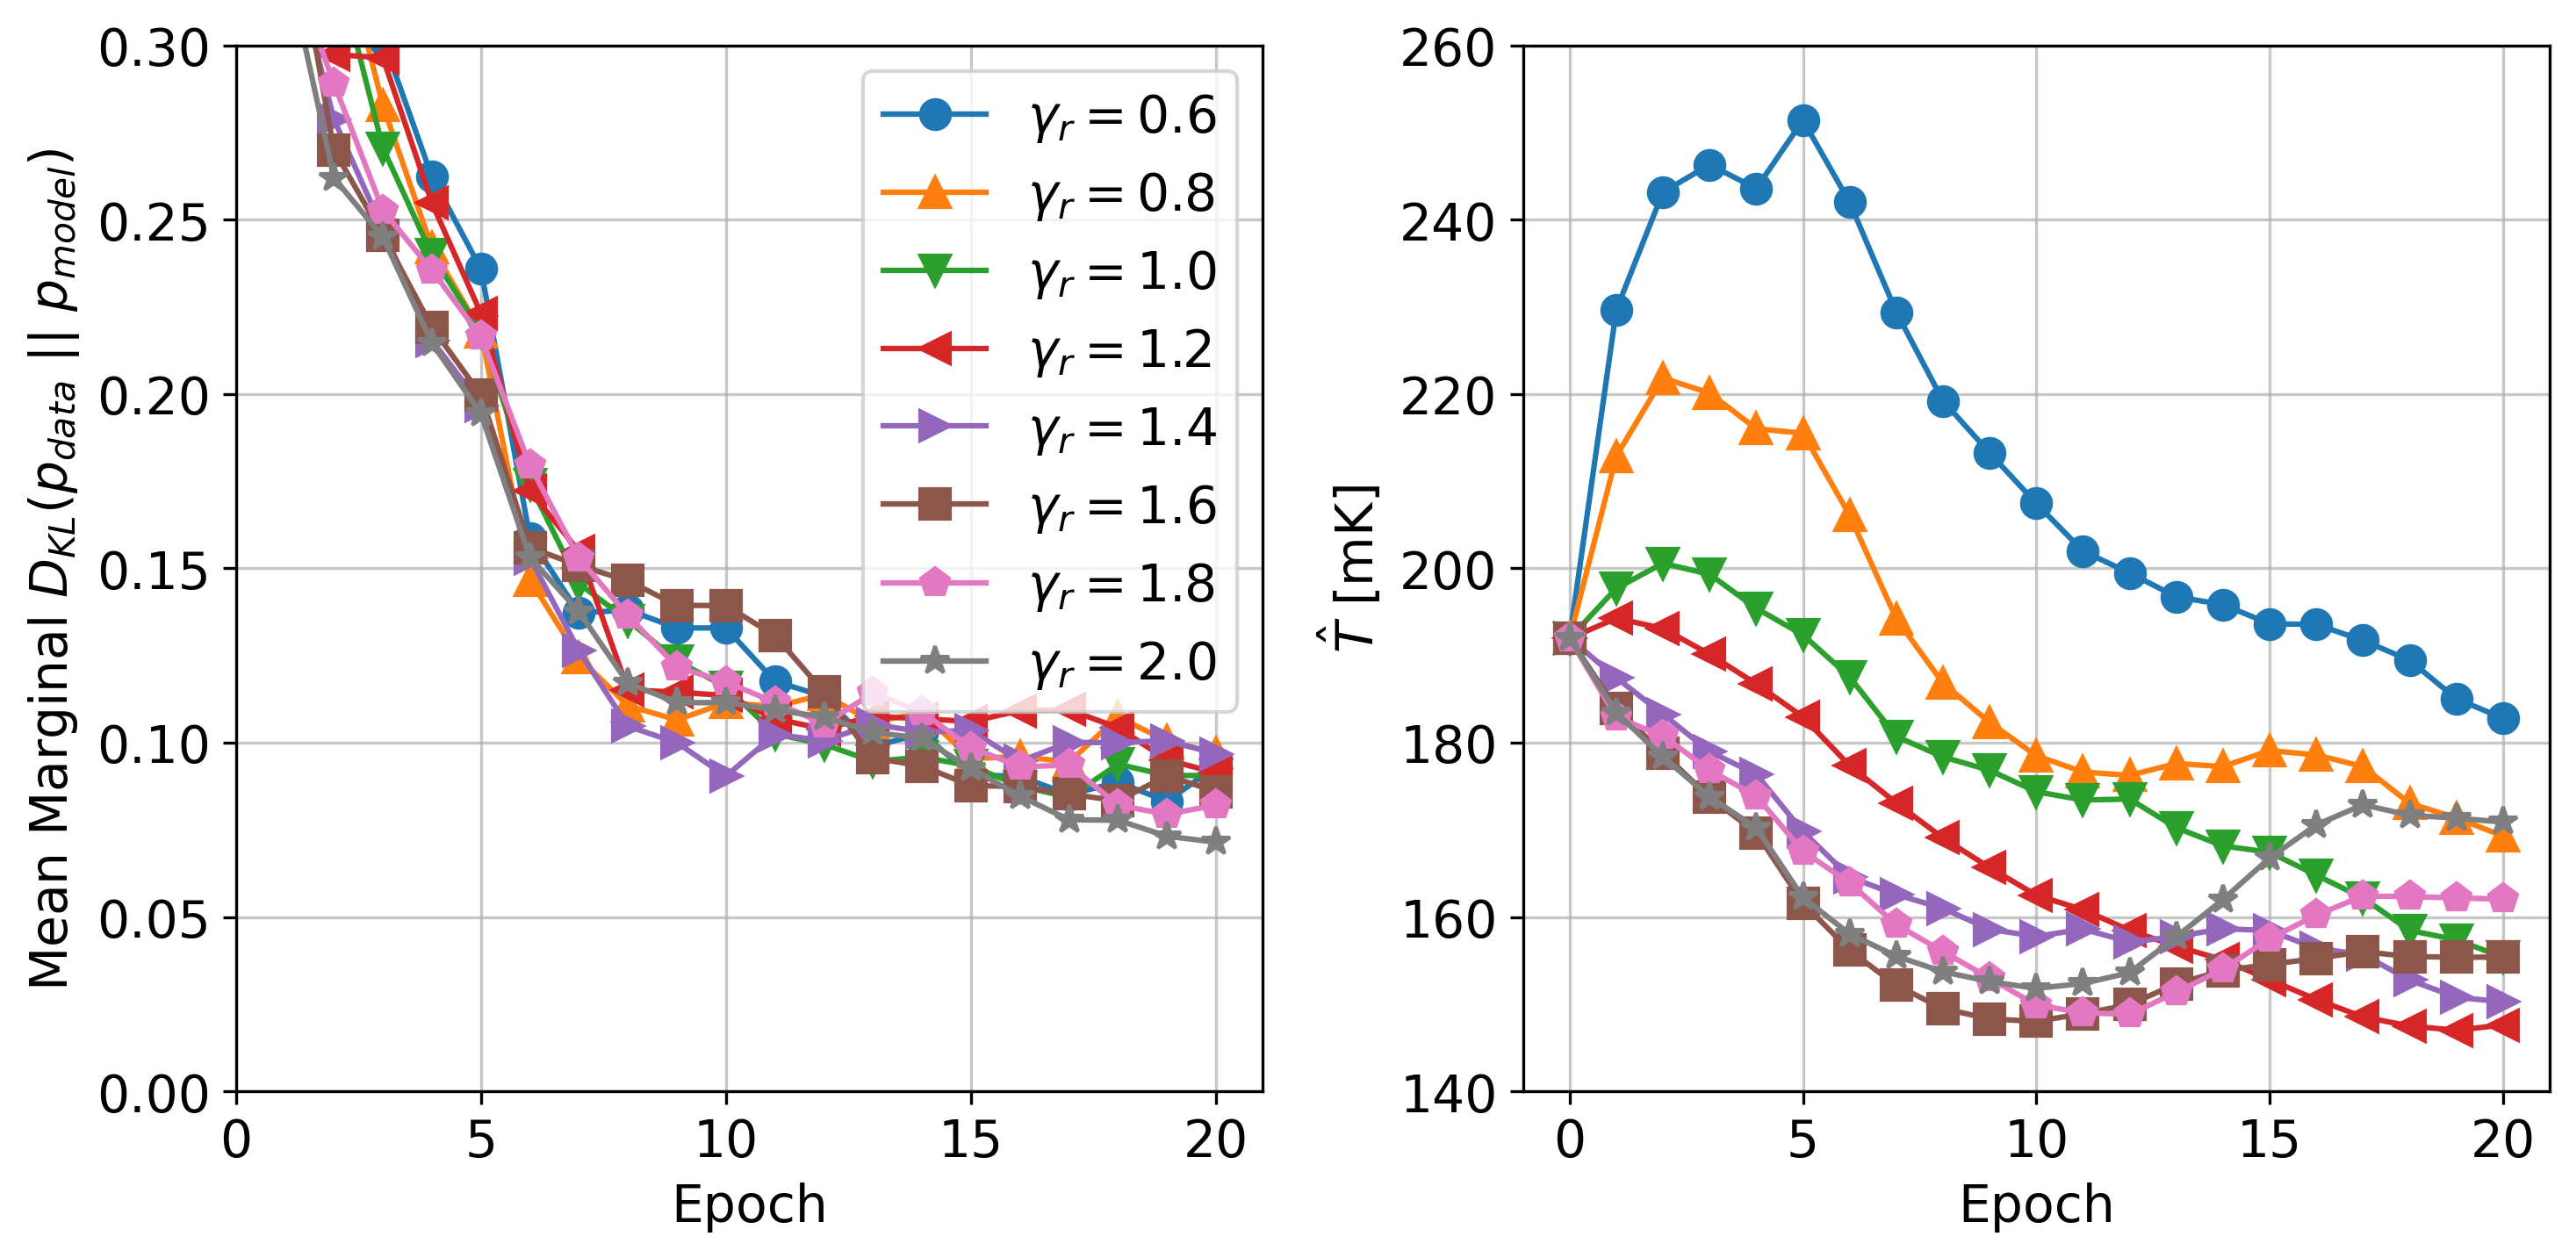

time: 949 ms (started: 2022-03-17 15:22:45 +01:00)


In [7]:
def smooth(x, k=5):
    x_out = np.zeros(len(x))
    for i in range(len(x)):
        x_out[i] = np.mean(x[i - min((k - 1, i)) : i + 1])
    return x_out


fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
markers = ["o", "^", "v", "<", ">", "s", "p", "*", "P", "X"]
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]
for i, ((s_quench, relative_chain_strength), dkl) in enumerate(dkls_rcs.items()):
    ax[0].plot(
        range(1, len(dkl) + 1),
        smooth(dkl),
        label=fr"$\gamma_{{r}} = {relative_chain_strength}$",
        markersize=8,
        marker=markers[i],
        color=colors[i],
    )
for i, ((s_quench, relative_chain_strength), betas) in enumerate(beta_rcs.items()):
    ax[1].plot(
        range(len(betas)),
        smooth(1 / k_B / np.array(betas) * 1000),
        markersize=8,
        marker=markers[i],
        color=colors[i],
    )
# fig.suptitle("Embedding 1, $s_{quench}$ = 0.55, 5 Epoch Moving Average")
ax[0].set_ylabel(r"Mean Marginal $D_{KL}(p_{data} \ || \ p_{model})$")
ax[1].set_ylabel(r"$\hat{T}$ [mK]")
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_xticks(np.arange(0, 25, 5))
ax[1].set_xticks(np.arange(0, 25, 5))
ax[1].set_yticks(np.arange(140, 280, 20))
ax[0].set_ylim((0, 0.3))
ax[0].grid(alpha=0.7)
ax[1].grid(alpha=0.7)
ax[0].legend()
plt.tight_layout()
plt.savefig(plots_dir / "rcs_comparison.png")

### $s_{\text{quench}}$ Comparison

In [8]:
models_s_quench = {}
s_freeze = 1.0
embedding_id = 1
for s_quench in [0.5, 0.55, 0.6]:
    for relative_chain_strength in [2.0]:
        if relative_chain_strength is not None:
            model_name = f"model-s_freeze={s_freeze:.2f}-s_quench={s_quench:.2f}-rcs={relative_chain_strength:.2f}"
        else:
            model_name = f"model-s_freeze={s_freeze:.2f}-s_quench={s_quench:.2f}-rcs={relative_chain_strength}"
        model_path = models_dir / f"embedding_{embedding_id:02}/{model_name}.pkl"
        models_s_quench[s_quench, relative_chain_strength] = BQRBM.load(model_path)

dkls_s_quench = {}
ccs_s_quench = {}
beta_s_quench = {}
for (s_quench, relative_chain_strength), model in models_s_quench.items():
    dkls_s_quench[s_quench, relative_chain_strength] = [
        x["value"]["dkls"].mean().mean() for x in model.callback_outputs
    ][:20]
    ccs_s_quench[s_quench, relative_chain_strength] = [
        x["value"]["ccs"].abs().mean().mean() for x in model.callback_outputs
    ][:20]
    beta_s_quench[s_quench, relative_chain_strength] = model.beta_history[:21]

time: 5.18 s (started: 2022-03-17 15:22:46 +01:00)


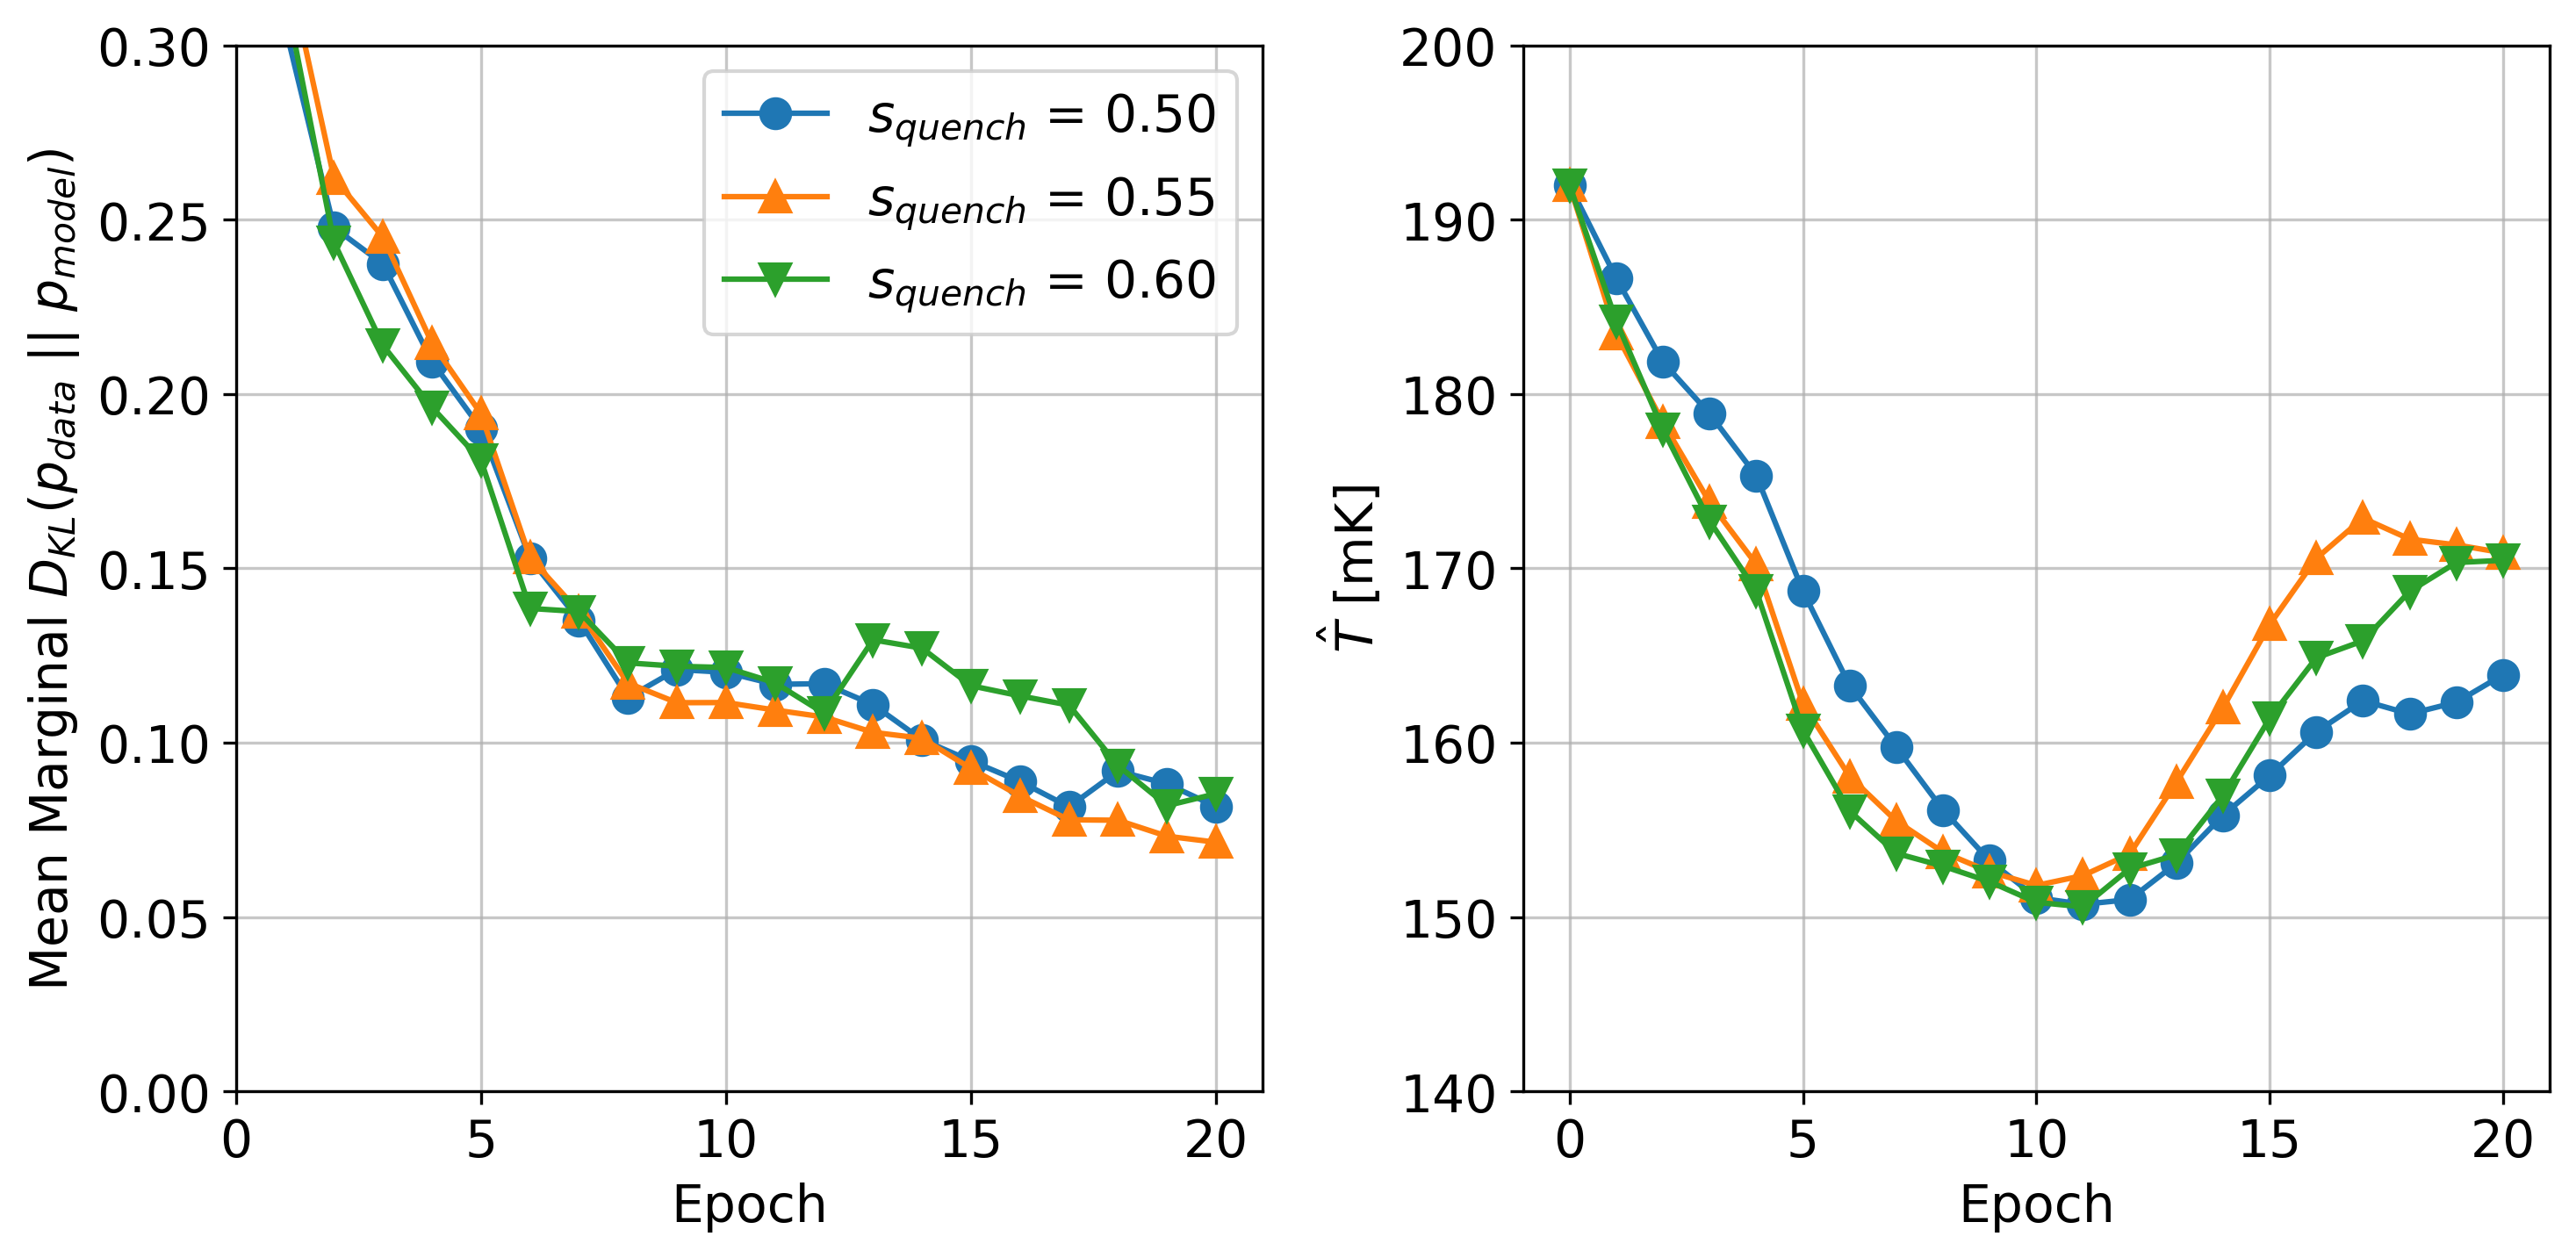

time: 636 ms (started: 2022-03-17 15:22:51 +01:00)


In [9]:
def smooth(x, k=5):
    x_out = np.zeros(len(x))
    for i in range(len(x)):
        x_out[i] = np.mean(x[i - min((k - 1, i)) : i + 1])
    return x_out


fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
markers = ["o", "^", "v", "<", ">", "s", "p", "*", "P", "X"]
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]
for i, ((s_quench, relative_chain_strength), dkl) in enumerate(dkls_s_quench.items()):
    ax[0].plot(
        range(1, len(dkl) + 1),
        smooth(dkl),
        label=f"$s_{{quench}}$ = {s_quench:.2f}",
        markersize=8,
        marker=markers[i],
        color=colors[i],
    )
for i, ((s_quench, relative_chain_strength), betas) in enumerate(beta_s_quench.items()):
    ax[1].plot(
        range(len(betas)),
        smooth(1 / k_B / np.array(betas) * 1000),
        markersize=8,
        marker=markers[i],
        color=colors[i],
    )
# fig.suptitle("Embedding 1, RCS = 2, 5 Epoch Moving Average")
ax[0].set_ylabel(r"Mean Marginal $D_{KL}(p_{data} \ || \ p_{model})$")
ax[1].set_ylabel(r"$\hat{T}$ [mK]")
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_xticks(np.arange(0, 25, 5))
ax[1].set_xticks(np.arange(0, 25, 5))
ax[1].set_yticks(np.arange(140, 210, 10))
ax[0].set_ylim((0, 0.3))
ax[0].grid(alpha=0.7)
ax[1].grid(alpha=0.7)
ax[0].legend()
plt.tight_layout()
plt.savefig(plots_dir / "s_quench_comparison.png")

## Embedding Comparison

In [10]:
# set the model params
train_model = False
beta_initial = 0.25
beta_range = (0.01, 10)
n_epochs = 20
learning_rate = 2e-2
learning_rate_beta = 1e-2
mini_batch_size = 10
s_freeze = 1.0
s_quench = 0.55
relative_chain_strength = 2.0

# set the anneal params
t_a = 20
α_quench = 2
t_quench = round(s_quench * t_a, 3)
Δ_quench = round((1 - s_quench) / α_quench, 3)
if s_quench == 1:
    anneal_schedule = [(0, 0), (t_quench, s_quench)]
else:
    anneal_schedule = [
        (0, 0),
        (t_quench, s_quench),
        (round(t_quench + Δ_quench, 3), 1),
    ]
anneal_params = {
    "s": s_freeze,
    "A": df_anneal.loc[s_freeze, "A(s) (GHz)"],
    "B": df_anneal.loc[s_freeze, "B(s) (GHz)"],
    "schedule": anneal_schedule,
}

# train the models
anneal_params["relative_chain_strength"] = relative_chain_strength

for embedding_id in [1, 2, 3, 4, 5]:
    # set model name and path
    if relative_chain_strength is not None:
        model_name = f"model-s_freeze={s_freeze:.2f}-s_quench={s_quench:.2f}-rcs={relative_chain_strength:.2f}"
    else:
        model_name = f"model-s_freeze={s_freeze:.2f}-s_quench={s_quench:.2f}-rcs={relative_chain_strength}"
    model_path = models_dir / f"embedding_{embedding_id:02}/{model_name}.pkl"
    if train_model:
        print(model_path)
        if model_path.exists():
            print(f"Model already exists")
            continue

        # model init
        model = BQRBM(
            X_train=X_train,
            n_hidden=model_params["n_hidden"],
            embedding=embeddings[embedding_id],
            anneal_params=anneal_params,
            beta_initial=beta_initial,
            beta_range=beta_range,
            qpu_params=qpu_params,
        )

        # model train and save
        model.train(
            n_epochs=n_epochs,
            learning_rate=learning_rate,
            learning_rate_beta=learning_rate_beta,
            mini_batch_size=mini_batch_size,
            callback=callback,
        )
        model.save(model_path)

        # save attributes as dict in case of error loading old pickled object
        model_attributes = {
            "A": model.A,
            "B": model.B,
            "a": model.a,
            "b": model.b,
            "W": model.W,
            "beta": model.beta,
            "embedding": model.embedding,
            "qpu_params": model.qpu_params,
            "anneal_params": model.anneal_params,
            "exact_params": model.exact_params,
            "beta_history": model.beta_history,
            "callback_outputs": [x for x in model.callback_outputs],
        }
        save_artifact(
            model_attributes,
            Path(str(model_path).replace("model-", "model_attributes-")),
        )

time: 1.68 ms (started: 2022-03-17 15:22:52 +01:00)


In [11]:
models_embeddings = {}
s_freeze = 1.0
s_quench = 0.55
embedding_ids = [1, 2, 3, 4, 5]
relative_chain_strength = 2.0
for embedding_id in embedding_ids:
    model_name = f"model-s_freeze={s_freeze:.2f}-s_quench={s_quench:.2f}-rcs={relative_chain_strength:.2f}"
    model_path = models_dir / f"embedding_{embedding_id:02}/{model_name}.pkl"
    models_embeddings[embedding_id] = BQRBM.load(model_path)

dkls_embeddings = {}
ccs_embeddings = {}
beta_embeddings = {}
for embedding_id, model in models_embeddings.items():
    dkls_embeddings[embedding_id] = [
        x["value"]["dkls"].mean().mean() for x in model.callback_outputs
    ][:20]
    ccs_embeddings[embedding_id] = [
        x["value"]["ccs"].abs().mean().mean() for x in model.callback_outputs
    ][:20]
    beta_embeddings[embedding_id] = model.beta_history[:21]

time: 8.78 s (started: 2022-03-17 15:22:52 +01:00)


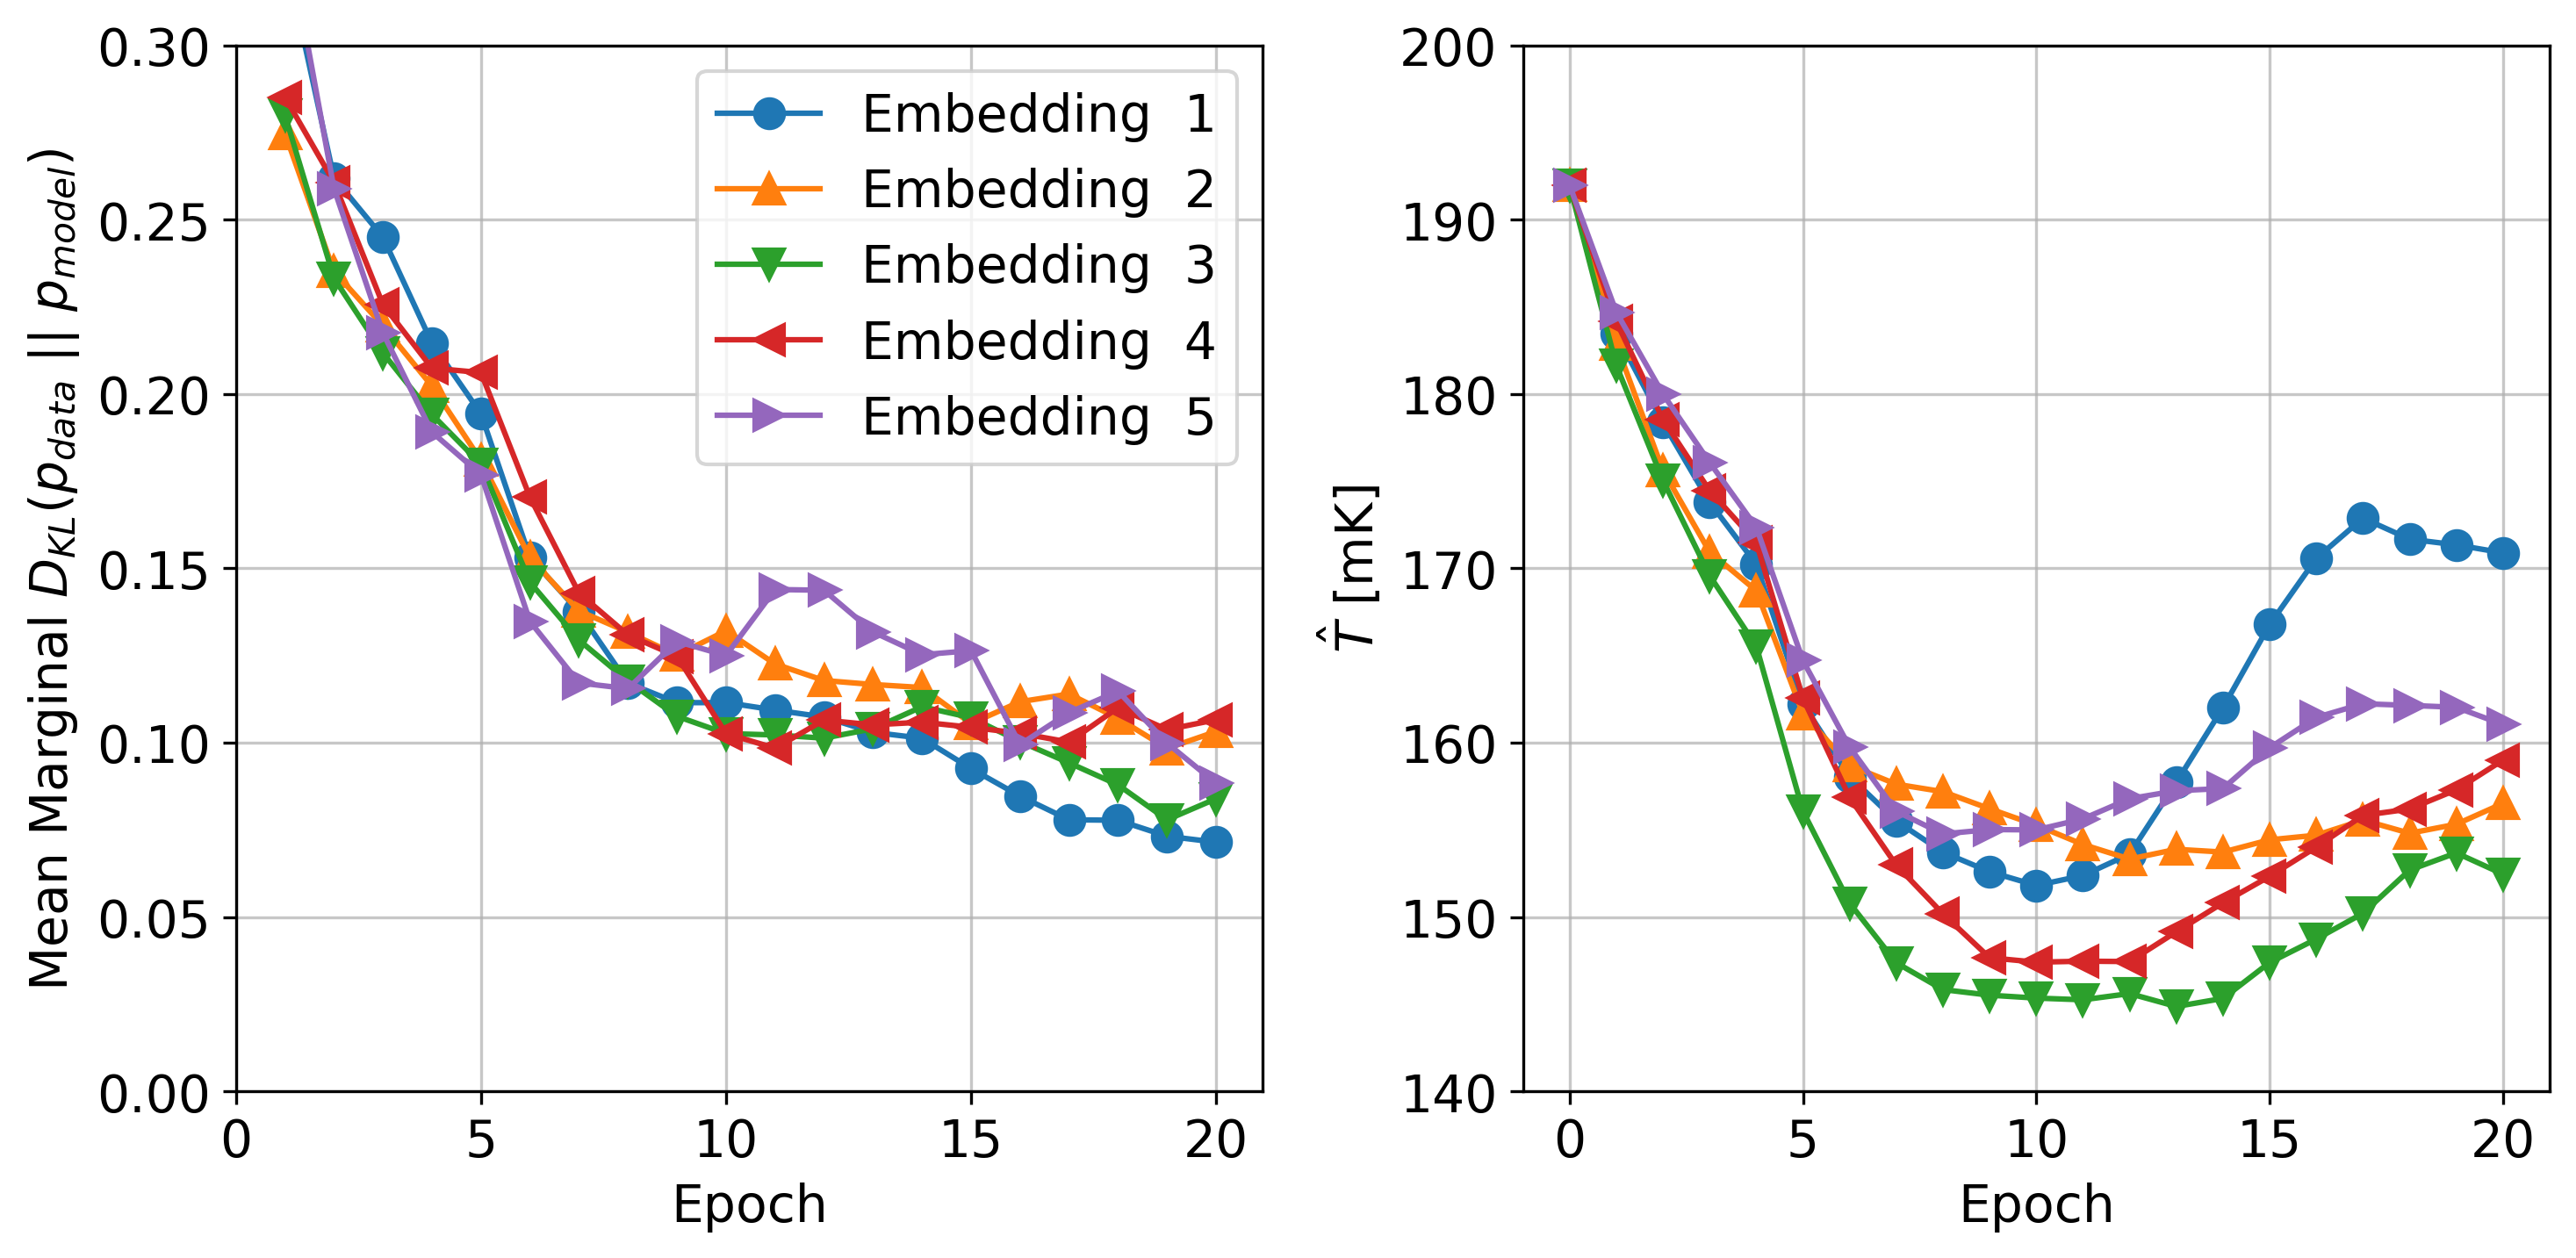

time: 657 ms (started: 2022-03-17 15:23:01 +01:00)


In [12]:
def smooth(x, k=5):
    x_out = np.zeros(len(x))
    for i in range(len(x)):
        x_out[i] = np.mean(x[i - min((k - 1, i)) : i + 1])
    return x_out


fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
markers = ["o", "^", "v", "<", ">", "s", "p", "*", "P", "X"]
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]
for i, (embedding_id, dkl) in enumerate(dkls_embeddings.items()):
    ax[0].plot(
        range(1, len(dkl) + 1),
        smooth(dkl),
        label=f"Embedding {embedding_id:2}",
        markersize=8,
        marker=markers[i],
        color=colors[i],
    )
for i, (embedding_id, betas) in enumerate(beta_embeddings.items()):
    ax[1].plot(
        range(len(betas)),
        smooth(1 / k_B / np.array(betas) * 1000),
        markersize=8,
        marker=markers[i],
        color=colors[i],
    )
# fig.suptitle("$s_{quench}$ = 0.55, RCS = 2, 5 Epoch Moving Average")
ax[0].set_ylabel(r"Mean Marginal $D_{KL}(p_{data} \ || \ p_{model})$")
ax[1].set_ylabel(r"$\hat{T}$ [mK]")
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_xticks(np.arange(0, 25, 5))
ax[1].set_xticks(np.arange(0, 25, 5))
ax[1].set_yticks(np.arange(140, 210, 10))
ax[0].set_ylim((0, 0.3))
ax[0].grid(alpha=0.7)
ax[1].grid(alpha=0.7)
ax[0].legend()
plt.tight_layout()
plt.savefig(plots_dir / "embedding_comparison.png")

## Train Full Model

In [13]:
# set the model params
train_model = False
embedding_id = 1
n_epochs = 100
learning_rate = 1e-2
learning_rates = learning_rate * lr_exp_decay(
    range(1, n_epochs + 1), decay_epoch=50, period=10
)
learning_rates_beta = learning_rate * lr_exp_decay(
    range(1, n_epochs + 1), decay_epoch=50, period=20
)
mini_batch_size = 10
s_freeze = 1.0
s_quench = 0.55
relative_chain_strength = 2.0

# anneal schedule
t_a = 20
α_quench = 2
t_quench = round(s_quench * t_a, 3)
Δ_quench = round((1 - s_quench) / α_quench, 3)
if s_quench == 1:
    anneal_schedule = [(0, 0), (t_quench, s_quench)]
else:
    anneal_schedule = [
        (0, 0),
        (t_quench, s_quench),
        (round(t_quench + Δ_quench, 3), 1),
    ]
anneal_params = {
    "s": s_freeze,
    "A": df_anneal.loc[s_freeze, "A(s) (GHz)"],
    "B": df_anneal.loc[s_freeze, "B(s) (GHz)"],
    "schedule": anneal_schedule,
}

# set model name and path
model_name = f"model-final"
model_path = models_dir / f"embedding_{embedding_id:02}/{model_name}.pkl"
if train_model:
    # model train and save
    model = BQRBM(
        X_train=X_train,
        n_hidden=model_params["n_hidden"],
        embedding=embeddings[embedding_id],
        anneal_params=anneal_params,
        beta_initial=beta_initial,
        beta_range=beta_range,
        qpu_params=qpu_params,
    )
    model.train(
        n_epochs=n_epochs,
        learning_rate=learning_rates,
        learning_rate_beta=learning_rates_beta,
        mini_batch_size=mini_batch_size,
        callback=callback,
    )
    model.save(model_path)

    # save attributes as dict in case of error loading old pickled object
    model_attributes = {
        "A": model.A,
        "B": model.B,
        "a": model.a,
        "b": model.b,
        "W": model.W,
        "beta": model.beta,
        "embedding": model.embedding,
        "qpu_params": model.qpu_params,
        "anneal_params": model.anneal_params,
        "exact_params": model.exact_params,
        "beta_history": model.beta_history,
        "callback_outputs": [x for x in model.callback_outputs],
    }
    save_artifact(
        model_attributes, Path(str(model_path).replace("model-", "model_attributes-")),
    )
else:
    model_final = BQRBM.load(model_path)

time: 1.66 s (started: 2022-03-17 15:23:01 +01:00)


In [14]:
embedding_id = 1
model_name = f"model-final"
model_path = models_dir / f"embedding_{embedding_id:02}/{model_name}.pkl"
model_final = BQRBM.load(model_path)

dkls_final = {}
ccs_final = {}
beta_final = {}
dkls_final[embedding_id] = [
    x["value"]["dkls"].mean().mean() for x in model_final.callback_outputs
]
ccs_final[embedding_id] = [
    x["value"]["ccs"].abs().mean().mean() for x in model_final.callback_outputs
]
beta_final[embedding_id] = model_final.beta_history

time: 1.68 s (started: 2022-03-17 15:23:03 +01:00)


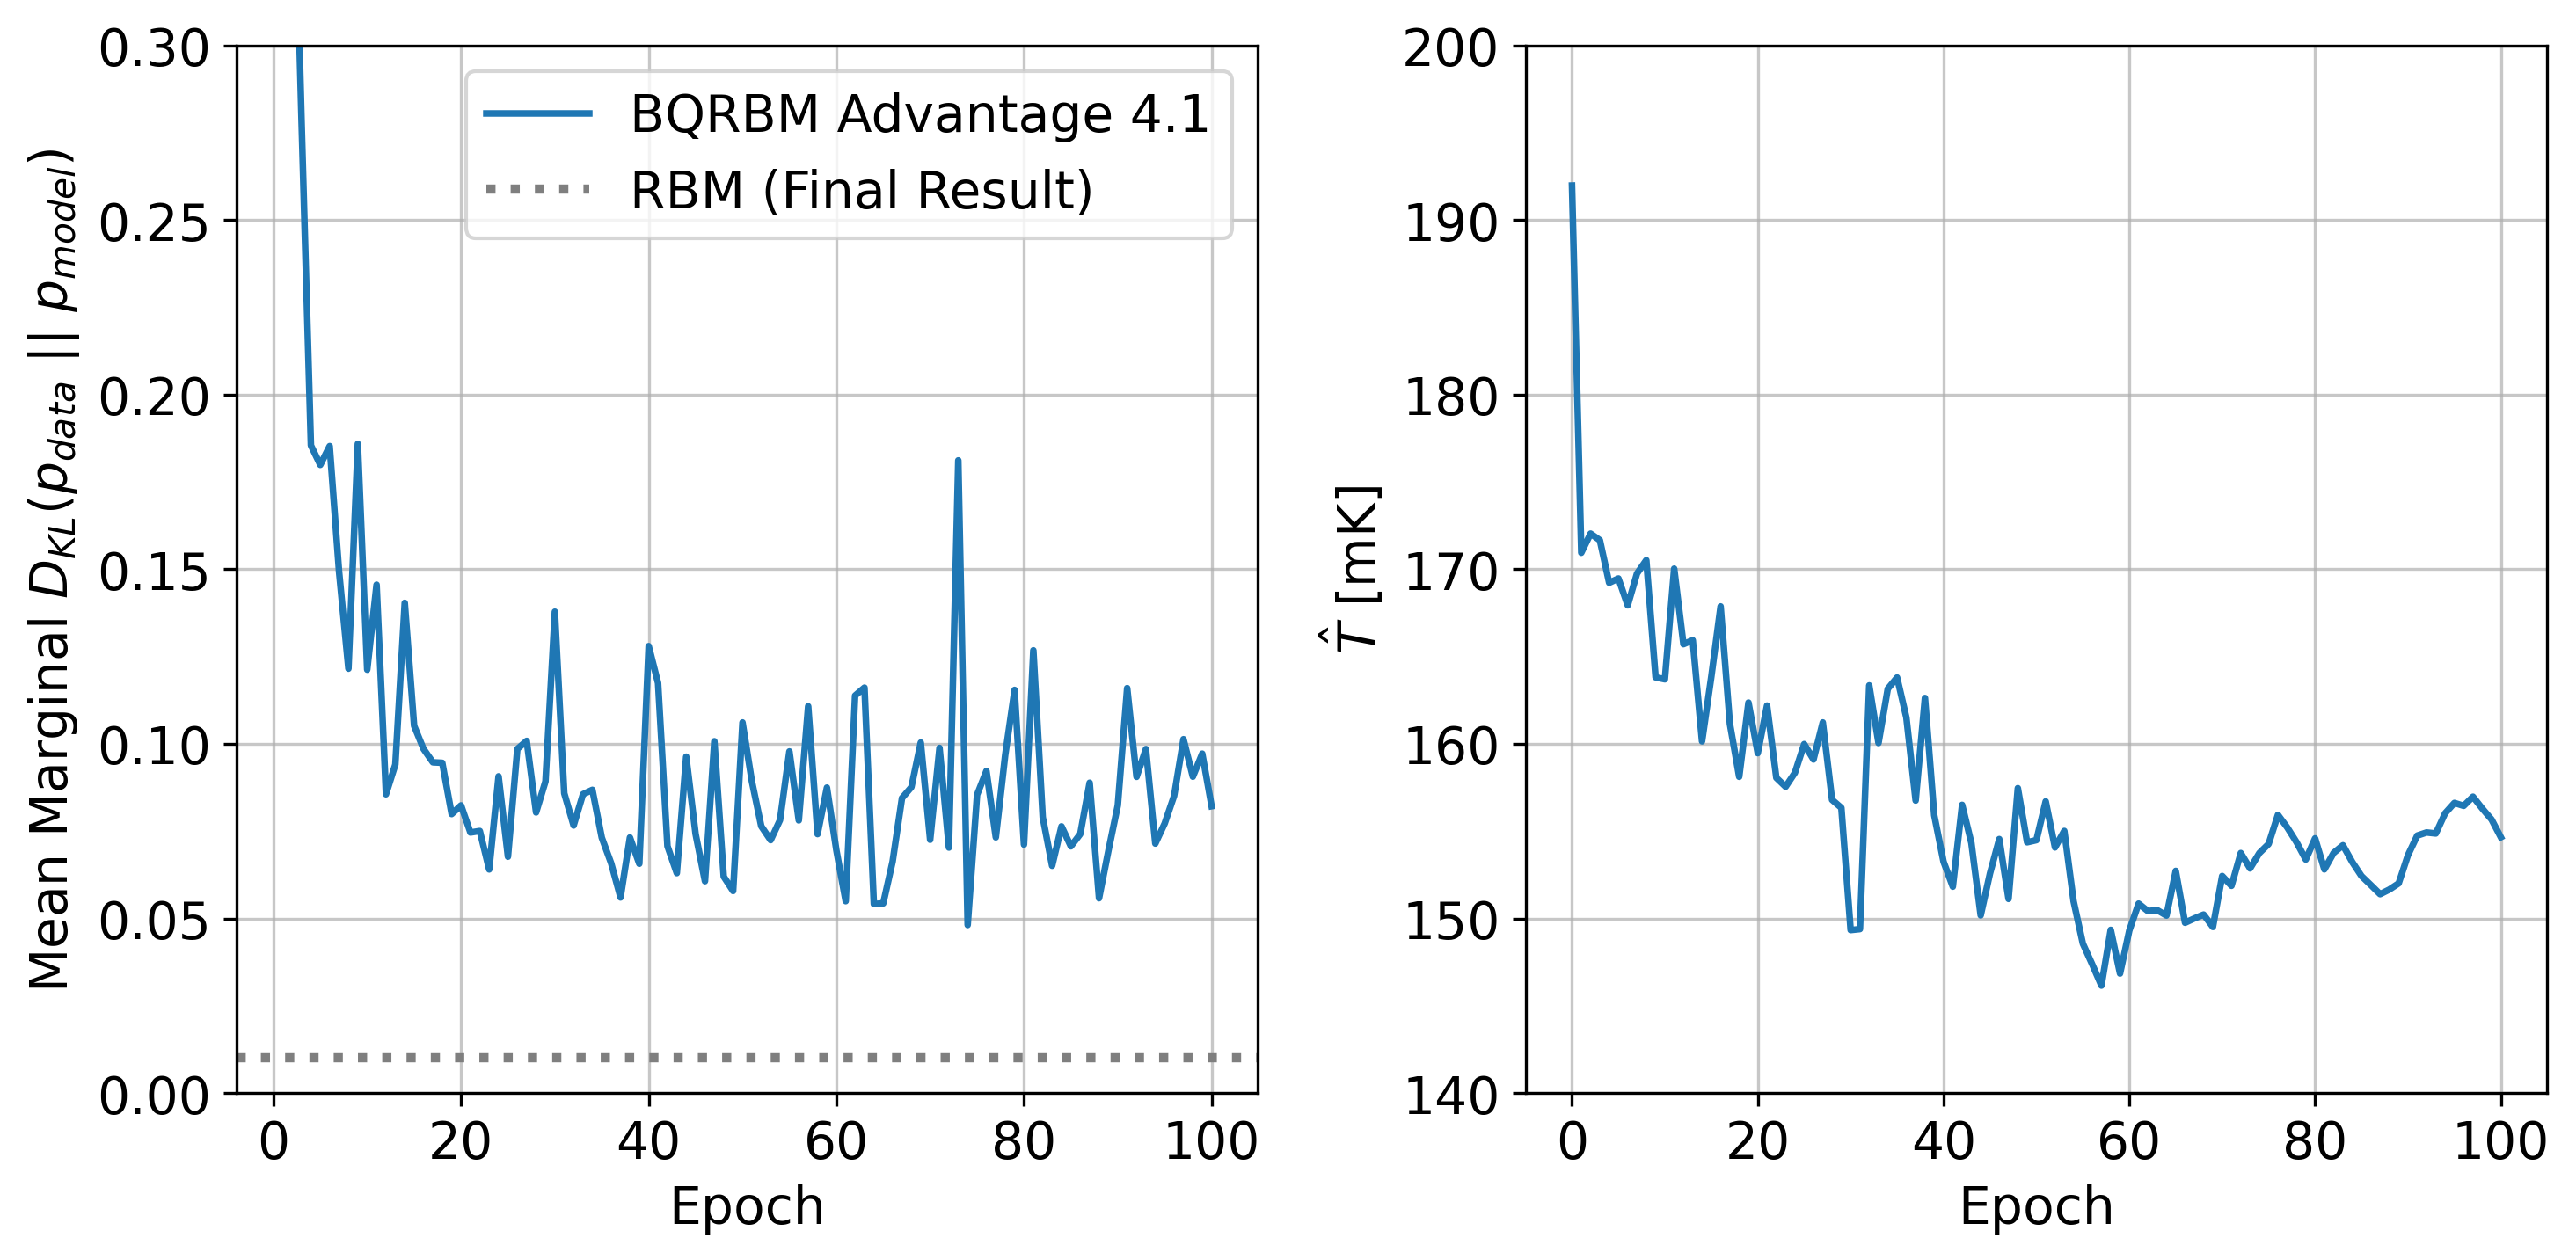

time: 618 ms (started: 2022-03-17 15:23:05 +01:00)


In [15]:
def smooth(x, k=1):
    x_out = np.zeros(len(x))
    for i in range(len(x)):
        x_out[i] = np.mean(x[i - min((k - 1, i)) : i + 1])
    return x_out


fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
markers = ["o", "^", "v", "<", ">", "s", "p", "*", "P", "X"]
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]
for i, (embedding_id, dkl) in enumerate(dkls_final.items()):
    ax[0].plot(
        range(1, len(dkl) + 1),
        smooth(dkl),
        label=f"BQRBM Advantage 4.1",
        color=colors[i],
        linewidth=1.8,
    )
for i, (embedding_id, betas) in enumerate(beta_final.items()):
    ax[1].plot(
        range(len(betas)),
        smooth(1 / k_B / np.array(betas) * 1000),
        color=colors[i],
        linewidth=1.8,
    )
ax[0].axhline(
    0.01,
    color="tab:gray",
    linewidth=2.5,
    linestyle="dotted",
    label="RBM (Final Result)",
)
# fig.suptitle("Embedding 1, $s_{quench}$ = 0.55, RCS = 2")
ax[0].set_ylabel(r"Mean Marginal $D_{KL}(p_{data} \ || \ p_{model})$")
ax[1].set_ylabel(r"$\hat{T}$ [mK]")
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_xticks(np.arange(0, 105, 20))
ax[1].set_xticks(np.arange(0, 105, 20))
ax[1].set_yticks(np.arange(140, 210, 10))
ax[0].set_ylim((0, 0.3))
ax[0].grid(alpha=0.7)
ax[1].grid(alpha=0.7)
ax[0].legend()
plt.tight_layout()
plt.savefig(plots_dir / "full_run.png")

## Analysis

In [16]:
ensemble_size = 100
samples_ensemble = {}
for i in range(1, ensemble_size + 1):
    samples_path = samples_dir / f"model-final/{i:02}.pkl"
    if samples_path.exists():
        samples_ensemble[i] = load_artifact(samples_path)
    else:
        samples_ensemble[i] = model_final.sample(n_samples=10_000, binary=True)
        save_artifact(samples_ensemble[i], samples_path)

for i, samples in samples_ensemble.items():
    samples_ensemble[i] = convert_state_vectors_to_df(
        samples.record.sample[:, : model_final.n_visible]
    )

time: 52.1 s (started: 2022-03-17 15:23:05 +01:00)


### KL Divergences

In [17]:
rbm_artifacts_path = project_dir / "artifacts/BernoulliRBM_20211115_111609"
rbm_data_path = rbm_artifacts_path / "results/data"
tables_dir = project_dir / "latex/tables/qbm"
if not tables_dir.exists():
    tables_dir.mkdir(parents=True)


def str_map(x, digits=2, factor=1):
    return f"{x * factor:0.{digits}f}"


def save_table(table, file_name):
    with open(tables_dir / file_name, "w", encoding="utf-8") as f:
        f.write(table + "\n")


def textbf(x):
    return "\\textbf{%s}" % x

time: 2.01 ms (started: 2022-03-17 15:23:58 +01:00)


In [18]:
dkls_ensemble = []
for i, df_sample in samples_ensemble.items():
    dkls = {
        column: kl_divergence(
            log_returns[column], df_sample[column], n_bins=32, smooth=1e-6
        )
        for column in log_returns.columns
    }
    dkls = pd.DataFrame.from_dict(dkls, orient="index", columns=["D_KL"])
    dkls_ensemble.append(dkls)
dkls_bqrbm = compute_stats_over_dfs(dkls_ensemble)
dkls_rbm = pd.read_csv(rbm_data_path / "kl_divergences.csv", index_col="currency_pair")
dkls = pd.DataFrame(
    {
        "bqrbm_means": dkls_bqrbm["means"].to_numpy().flatten(),
        "bqrbm_medians": dkls_bqrbm["medians"].to_numpy().flatten(),
        "bqrbm_stds": dkls_bqrbm["stds"].to_numpy().flatten(),
        "rbm_means": dkls_rbm["means"].to_numpy().flatten(),
        "rbm_medians": dkls_rbm["medians"].to_numpy().flatten(),
        "rbm_stds": dkls_rbm["stds"].to_numpy().flatten(),
    },
    index=dkls_bqrbm["means"].index,
)
dkls.index.set_names("currency_pair", inplace=True)
dkls.loc["Mean"] = dkls.mean()
dkls.loc["Mean", "bqrbm_stds"] = np.sqrt(
    np.sum(dkls_bqrbm["stds"]["D_KL"] ** 2) / (len(dkls_bqrbm["stds"]["D_KL"]))
)
dkls.loc["Mean", "rbm_stds"] = np.sqrt(
    np.sum(dkls_rbm["stds"] ** 2) / (len(dkls_rbm["stds"]))
)
dkls = dkls.applymap(str_map, digits=3)
dkls

,bqrbm_means,bqrbm_medians,bqrbm_stds,rbm_means,rbm_medians,rbm_stds
currency_pair,,,,,,
EURUSD,0.086,0.075,0.044,0.010,0.009,0.001
GBPUSD,0.062,0.051,0.037,0.007,0.007,0.001
USDCAD,0.064,0.059,0.028,0.017,0.017,0.002
USDJPY,0.103,0.095,0.037,0.008,0.008,0.001
Mean,0.079,0.070,0.037,0.010,0.010,0.001


time: 447 ms (started: 2022-03-17 15:23:58 +01:00)


In [19]:
prefixes = ["bqrbm", "rbm"]
table = [
    r"\begin{tabular}{l r r}",
    r"\multicolumn{3}{c}{\(D_{\text{KL}}(p_\text{data} \ || \ p_\text{model})\)} \\",
    r"\toprule",
    r"Currency Pair & \textbf{BQRBM} & \textbf{RBM}\\",
    r"\midrule",
]
for i, pair in enumerate(dkls.index):
    data = dkls.loc[pair]
    row = [pair]

    for prefix in prefixes:
        μ = data[f"{prefix}_means"]
        σ = data[f"{prefix}_stds"]
        row.append(fr"{μ} $\pm$ {σ}")

    row = " & ".join(row)
    row += r" \\"
    if i == len(dkls) - 1:
        table.append(r"\midrule")

    table.append(row)

table.append(r"\bottomrule")
table.append(r"\end{tabular}")
table = "\n".join(table)
save_table(table, "kl_divergences.tbl")

time: 1.37 ms (started: 2022-03-17 15:23:58 +01:00)


### QQ Plots

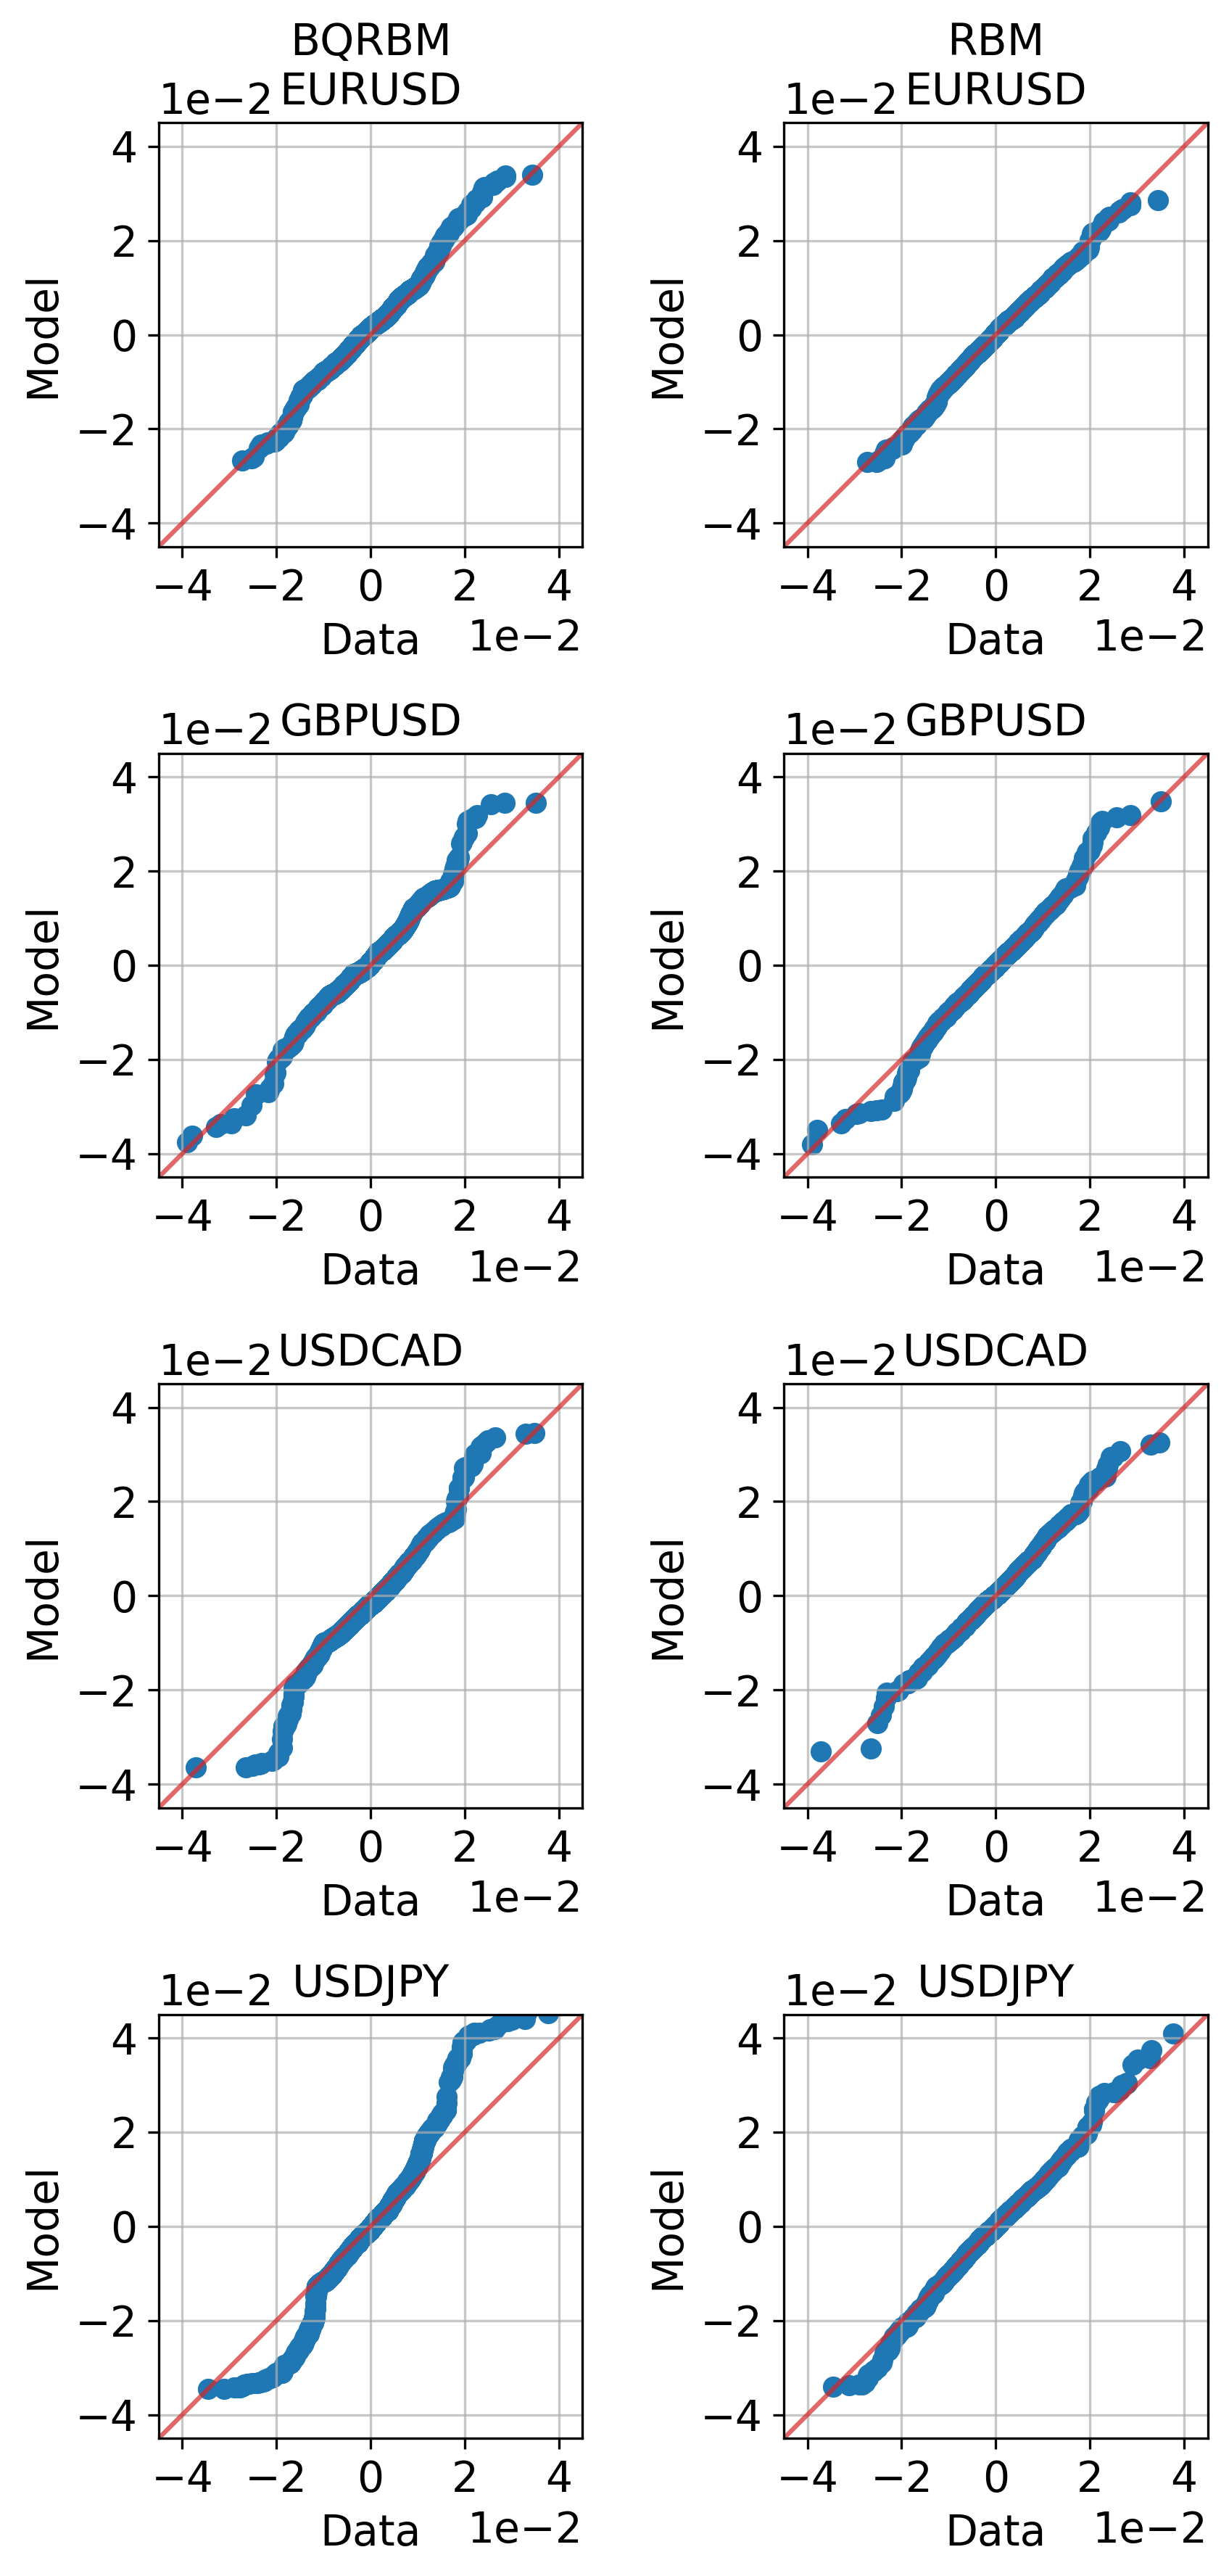

time: 2.09 s (started: 2022-03-17 15:23:58 +01:00)


In [20]:
def plot_qq_grid(data, sample, params):
    """
    Plots a 2x2 grid of QQ plots.

    :param data: A dataframe of shape (n_sample, 4).
    :param sample: A dataframe with matching column names to the data and the same shape.
    :param params: Additional parameter dictionary for ax configuration, required keys are
        ["xlims", "ylims", "xticks", "yticks"].

    :returns: Matplotlib figure and axes.
    """
    fig, axs = plt.subplots(1, 2, figsize=(9, 9), dpi=300, tight_layout=True)
    for column, ax in zip(data.columns, axs.flatten()):
        plot_qq(ax, data[column], sample[column], column, params)

    plt.tight_layout()

    return fig, axs


qq_plot_params = {
    "title": "test",
    "xlims": (-0.045, 0.045),
    "ylims": (-0.045, 0.045),
    "xticks": np.linspace(-0.04, 0.04, 5),
    "yticks": np.linspace(-0.04, 0.04, 5),
}
fig, axs = plt.subplots(4, 2, figsize=(6, 12), dpi=300)
matplotlib.rcParams.update({"font.size": 12})
samples_bqrbm_ = samples_ensemble[1]
samples_rbm_ = load_artifact(rbm_artifacts_path / f"samples_ensemble/{1:03}.pkl")
samples_qq = [samples_bqrbm_, samples_rbm_]
for j, samples_ in enumerate(samples_qq):
    if j == 0:
        title = "BQRBM"
    else:
        title = "RBM"
    for i, column in enumerate(log_returns.columns):
        if i == 0:
            title += f"\n{column}"
        else:
            title = column
        plot_qq(
            axs[i, j],
            log_returns[column],
            samples_[column][: len(log_returns[column])],
            title,
            qq_plot_params,
        )
        axs[i, j].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
        axs[i, j].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.tight_layout()
plt.savefig(plots_dir / "qq.png")

### Correlation Coefficients

In [21]:
ccs_ensemble = []
combinations = list(itertools.combinations(model_params["columns"], 2))
for i, df_sample in samples_ensemble.items():
    ccs_ensemble.append(compute_correlation_coefficients(df_sample, combinations))
ccs_bqrbm = compute_stats_over_dfs(ccs_ensemble)
ccs_bqrbm["means"].index.set_names("currency_pairs", inplace=True)
ccs_bqrbm["medians"].index.set_names("currency_pairs", inplace=True)
ccs_bqrbm["stds"].index.set_names("currency_pairs", inplace=True)
ccs_bqrbm["means"].rename(lambda x: f"bqrbm_{x}_mean", axis=1, inplace=True)
ccs_bqrbm["stds"].rename(lambda x: f"bqrbm_{x}_std", axis=1, inplace=True)

ccs_data = pd.read_csv(
    rbm_data_path / "correlation_coefficients_data.csv", index_col="currency_pairs"
)
ccs_rbm_means = pd.read_csv(
    rbm_data_path / "correlation_coefficients_sample_means.csv",
    index_col="currency_pairs",
)
ccs_rbm_stds = pd.read_csv(
    rbm_data_path / "correlation_coefficients_sample_stds.csv",
    index_col="currency_pairs",
)
ccs_data.rename(lambda x: f"Data_{x}", axis=1, inplace=True)
ccs_rbm_means.rename(lambda x: f"rbm_{x}_mean", axis=1, inplace=True)
ccs_rbm_stds.rename(lambda x: f"rbm_{x}_std", axis=1, inplace=True)

ccs = pd.concat(
    [ccs_bqrbm["means"], ccs_bqrbm["stds"], ccs_data, ccs_rbm_means, ccs_rbm_stds],
    axis=1,
)
ccs = ccs.applymap(str_map, digits=2)
ccs

,bqrbm_Pearson_mean,bqrbm_Spearman_mean,bqrbm_Kendall_mean,bqrbm_Pearson_std,bqrbm_Spearman_std,bqrbm_Kendall_std,Data_Pearson,Data_Spearman,Data_Kendall,rbm_Pearson_mean,rbm_Spearman_mean,rbm_Kendall_mean,rbm_Pearson_std,rbm_Spearman_std,rbm_Kendall_std
currency_pairs,,,,,,,,,,,,,,,
EURUSD/GBPUSD,0.37,0.44,0.30,0.04,0.05,0.04,0.62,0.62,0.44,0.48,0.53,0.38,0.01,0.01,0.01
EURUSD/USDCAD,-0.25,-0.30,-0.20,0.03,0.04,0.03,-0.44,-0.41,-0.29,-0.33,-0.34,-0.24,0.01,0.01,0.01
EURUSD/USDJPY,-0.12,-0.16,-0.11,0.03,0.04,0.02,-0.26,-0.30,-0.21,-0.21,-0.25,-0.17,0.01,0.01,0.01
GBPUSD/USDCAD,-0.24,-0.28,-0.19,0.02,0.03,0.02,-0.42,-0.37,-0.26,-0.31,-0.33,-0.22,0.01,0.01,0.01
GBPUSD/USDJPY,-0.12,-0.15,-0.10,0.02,0.03,0.02,-0.14,-0.21,-0.15,-0.15,-0.18,-0.13,0.01,0.01,0.01
USDCAD/USDJPY,0.05,0.06,0.04,0.02,0.02,0.01,0.00,0.06,0.04,0.06,0.07,0.05,0.01,0.01,0.01


time: 2.4 s (started: 2022-03-17 15:24:00 +01:00)


In [22]:
prefixes = ("bqrbm",)
cc_names = ("Pearson", "Spearman", "Kendall")
table = [
    r"\begin{tabular}{l r r r r r r}"
    r"\multicolumn{7}{c}{\textbf{Correlation Coefficients}} \\",
    r"\toprule",
    r"& \multicolumn{3}{c}{\textbf{Data}} & \multicolumn{3}{c}{\textbf{BQRBM}} \\"
    r"\cmidrule(lr){2-4}",
    r"\cmidrule(lr){5-7}",
    r"Currency Pairs & %s & %s & %s & %s & %s & %s \\" % (cc_names + cc_names),
    r"\midrule",
]
data_columns = [f"Data_{cc_name}" for cc_name in cc_names]
for pair in ccs.index:
    data = ccs.loc[pair]
    row = [pair]
    row += [data[column] for column in data_columns]

    for prefix in prefixes:
        for cc_name in cc_names:
            μ = data[f"{prefix}_{cc_name}_mean"]
            σ = data[f"{prefix}_{cc_name}_std"]
            row.append(fr"{μ} $\pm$ {σ}")

    row = " & ".join(row)
    row += r" \\"
    table.append(row)

prefixes = ("rbm",)
cc_names = ("Pearson", "Spearman", "Kendall")
table += [
    r"\midrule",
    r"& \multicolumn{3}{c}{\textbf{RBM}} & \\" r"\cmidrule(lr){2-4}",
    r"Currency Pairs & %s & %s & %s & & & \\" % cc_names,
    r"\midrule",
]
for pair in ccs.index:
    data = ccs.loc[pair]
    row = [pair]

    for prefix in prefixes:
        for cc_name in cc_names:
            μ = data[f"{prefix}_{cc_name}_mean"]
            σ = data[f"{prefix}_{cc_name}_std"]
            row.append(fr"{μ} $\pm$ {σ}")

    for cc_name in cc_names:
        row.append("")

    row = " & ".join(row)
    row += r" \\"
    table.append(row)

table.append(r"\bottomrule")
table.append(r"\end{tabular}")
table = "\n".join(table)
save_table(table, "correlation_coefficients.tbl")

time: 2.47 ms (started: 2022-03-17 15:24:03 +01:00)


### Volatilities

In [23]:
volatilities = pd.read_csv(
    rbm_data_path / "volatilities.csv", index_col="currency_pair"
)
volatilities.rename(
    columns={"Sample Mean": "rbm_sample_mean", "Sample Std": "rbm_sample_std"},
    inplace=True,
)
volatilities_bqrbm = compute_stats_over_dfs(
    [compute_annualized_volatility(samples) for samples in samples_ensemble.values()]
)
volatilities["bqrbm_sample_mean"] = volatilities_bqrbm["means"]
volatilities["bqrbm_sample_std"] = volatilities_bqrbm["stds"]
volatilities = volatilities.applymap(str_map, digits=2, factor=100)
volatilities

,Data,rbm_sample_mean,rbm_sample_std,bqrbm_sample_mean,bqrbm_sample_std
currency_pair,,,,,
EURUSD,9.78,9.98,0.11,10.17,0.79
GBPUSD,8.98,9.34,0.11,8.86,0.47
USDCAD,8.56,8.98,0.13,8.44,0.39
USDJPY,10.02,10.26,0.13,11.58,1.44


time: 130 ms (started: 2022-03-17 15:24:03 +01:00)


In [24]:
prefixes = ("bqrbm", "rbm")
table = [
    r"\begin{tabular}{l r r r}",
    r"\multicolumn{4}{c}{\textbf{Historical Volatilities}} \\",
    r"\toprule",
    r"Currency Pair & \textbf{Data} & \textbf{BQRBM} & \textbf{RBM}\\" r"\midrule",
]
for pair in volatilities.index:
    data = volatilities.loc[pair]
    row = [pair, fr"{data['Data']}\%"]

    for prefix in prefixes:
        μ = data[f"{prefix}_sample_mean"]
        σ = data[f"{prefix}_sample_std"]
        row.append(fr"{μ}\% $\pm$ {σ}\%")

    row = " & ".join(row)
    row += r" \\"
    table.append(row)

table.append(r"\bottomrule")
table.append(r"\end{tabular}")
table = "\n".join(table)
save_table(table, "volatilities.tbl")

time: 1.38 ms (started: 2022-03-17 15:24:03 +01:00)


### Tails

In [25]:
quantiles_bqrbm = []
for samples in samples_ensemble.values():
    quantiles_bqrbm.append(
        pd.DataFrame(
            {
                "quantile_01": samples.quantile(0.01),
                "quantile_99": samples.quantile(0.99),
            }
        )
    )
tails_bqrbm = compute_stats_over_dfs(quantiles_bqrbm)
tails_bqrbm_means = tails_bqrbm["means"]
tails_bqrbm_stds = tails_bqrbm["stds"]
tails_bqrbm_means.index.set_names("currency_pair", inplace=True)
tails_bqrbm_stds.index.set_names("currency_pair", inplace=True)
tails_bqrbm_means.rename(lambda x: f"bqrbm_{x}_mean", axis=1, inplace=True)
tails_bqrbm_stds.rename(lambda x: f"bqrbm_{x}_std", axis=1, inplace=True)

tails_data = pd.read_csv(rbm_data_path / "tails_data.csv", index_col="currency_pair")
tails_rbm_means = pd.read_csv(
    rbm_data_path / "tails_sample_means.csv", index_col="currency_pair"
)
tails_rbm_stds = pd.read_csv(
    rbm_data_path / "tails_sample_stds.csv", index_col="currency_pair"
)
tails_data.rename(lambda x: f"Data_{x}", axis=1, inplace=True)
tails_rbm_means.rename(lambda x: f"rbm_{x}_mean", axis=1, inplace=True)
tails_rbm_stds.rename(lambda x: f"rbm_{x}_std", axis=1, inplace=True)

tails = pd.concat(
    [tails_bqrbm_means, tails_bqrbm_stds, tails_data, tails_rbm_means, tails_rbm_stds],
    axis=1,
)
tails = tails.applymap(str_map, digits=2, factor=100)
tails

,bqrbm_quantile_01_mean,bqrbm_quantile_99_mean,bqrbm_quantile_01_std,bqrbm_quantile_99_std,Data_quantile_01,Data_quantile_99,rbm_quantile_01_mean,rbm_quantile_99_mean,rbm_quantile_01_std,rbm_quantile_99_std
currency_pair,,,,,,,,,,
EURUSD,-2.02,1.70,0.24,0.23,-1.64,1.62,-1.80,1.59,0.04,0.04
GBPUSD,-1.45,1.49,0.12,0.07,-1.47,1.42,-1.59,1.45,0.04,0.04
USDCAD,-1.43,1.50,0.17,0.12,-1.40,1.51,-1.54,1.61,0.05,0.04
USDJPY,-2.32,2.13,0.38,0.50,-1.70,1.59,-2.03,1.56,0.07,0.04


time: 494 ms (started: 2022-03-17 15:24:03 +01:00)


In [26]:
prefixes = ("bqrbm", "rbm")
table = [
    r"\begin{tabular}{l r r r}",
    r"\multicolumn{4}{c}{\textbf{Lower Tails (1st Percentile)}} \\",
    r"\toprule",
    r"Currency Pair & \textbf{Data} & \textbf{BQRBM} & \textbf{RBM} \\" r"\midrule",
]

columns_low = [column for column in tails.columns if "quantile_01" in column]
for pair in tails.index:
    data = tails.loc[pair]
    row = [pair, fr"{data['Data_quantile_01']}\%"]

    for prefix in prefixes:
        μ = data[f"{prefix}_quantile_01_mean"]
        σ = data[f"{prefix}_quantile_01_std"]
        row.append(fr"{μ}\% $\pm$ {σ}\%")

    row = " & ".join(row)
    row += r" \\"
    table.append(row)

table += [
    r"\bottomrule \\",
    r"\multicolumn{4}{c}{\textbf{Upper Tails (99th Percentile)}} \\",
    r"\toprule",
    r"Currency Pair & \textbf{Data} & \textbf{BQRBM} & \textbf{RBM} \\" r"\midrule",
]

columns_high = [column for column in tails.columns if "quantile_99" in column]
for pair in tails.index:
    data = tails.loc[pair]
    row = [pair, fr"{data['Data_quantile_99']}\%"]

    for prefix in prefixes:
        μ = data[f"{prefix}_quantile_99_mean"]
        σ = data[f"{prefix}_quantile_99_std"]
        row.append(fr"{μ}\% $\pm$ {σ}\%")

    row = " & ".join(row)
    row += r" \\"
    table.append(row)

table.append(r"\bottomrule")
table.append(r"\end{tabular}")
table = "\n".join(table)
save_table(table, "tails.tbl")

time: 4.47 ms (started: 2022-03-17 15:24:03 +01:00)


### Tail Concentrations

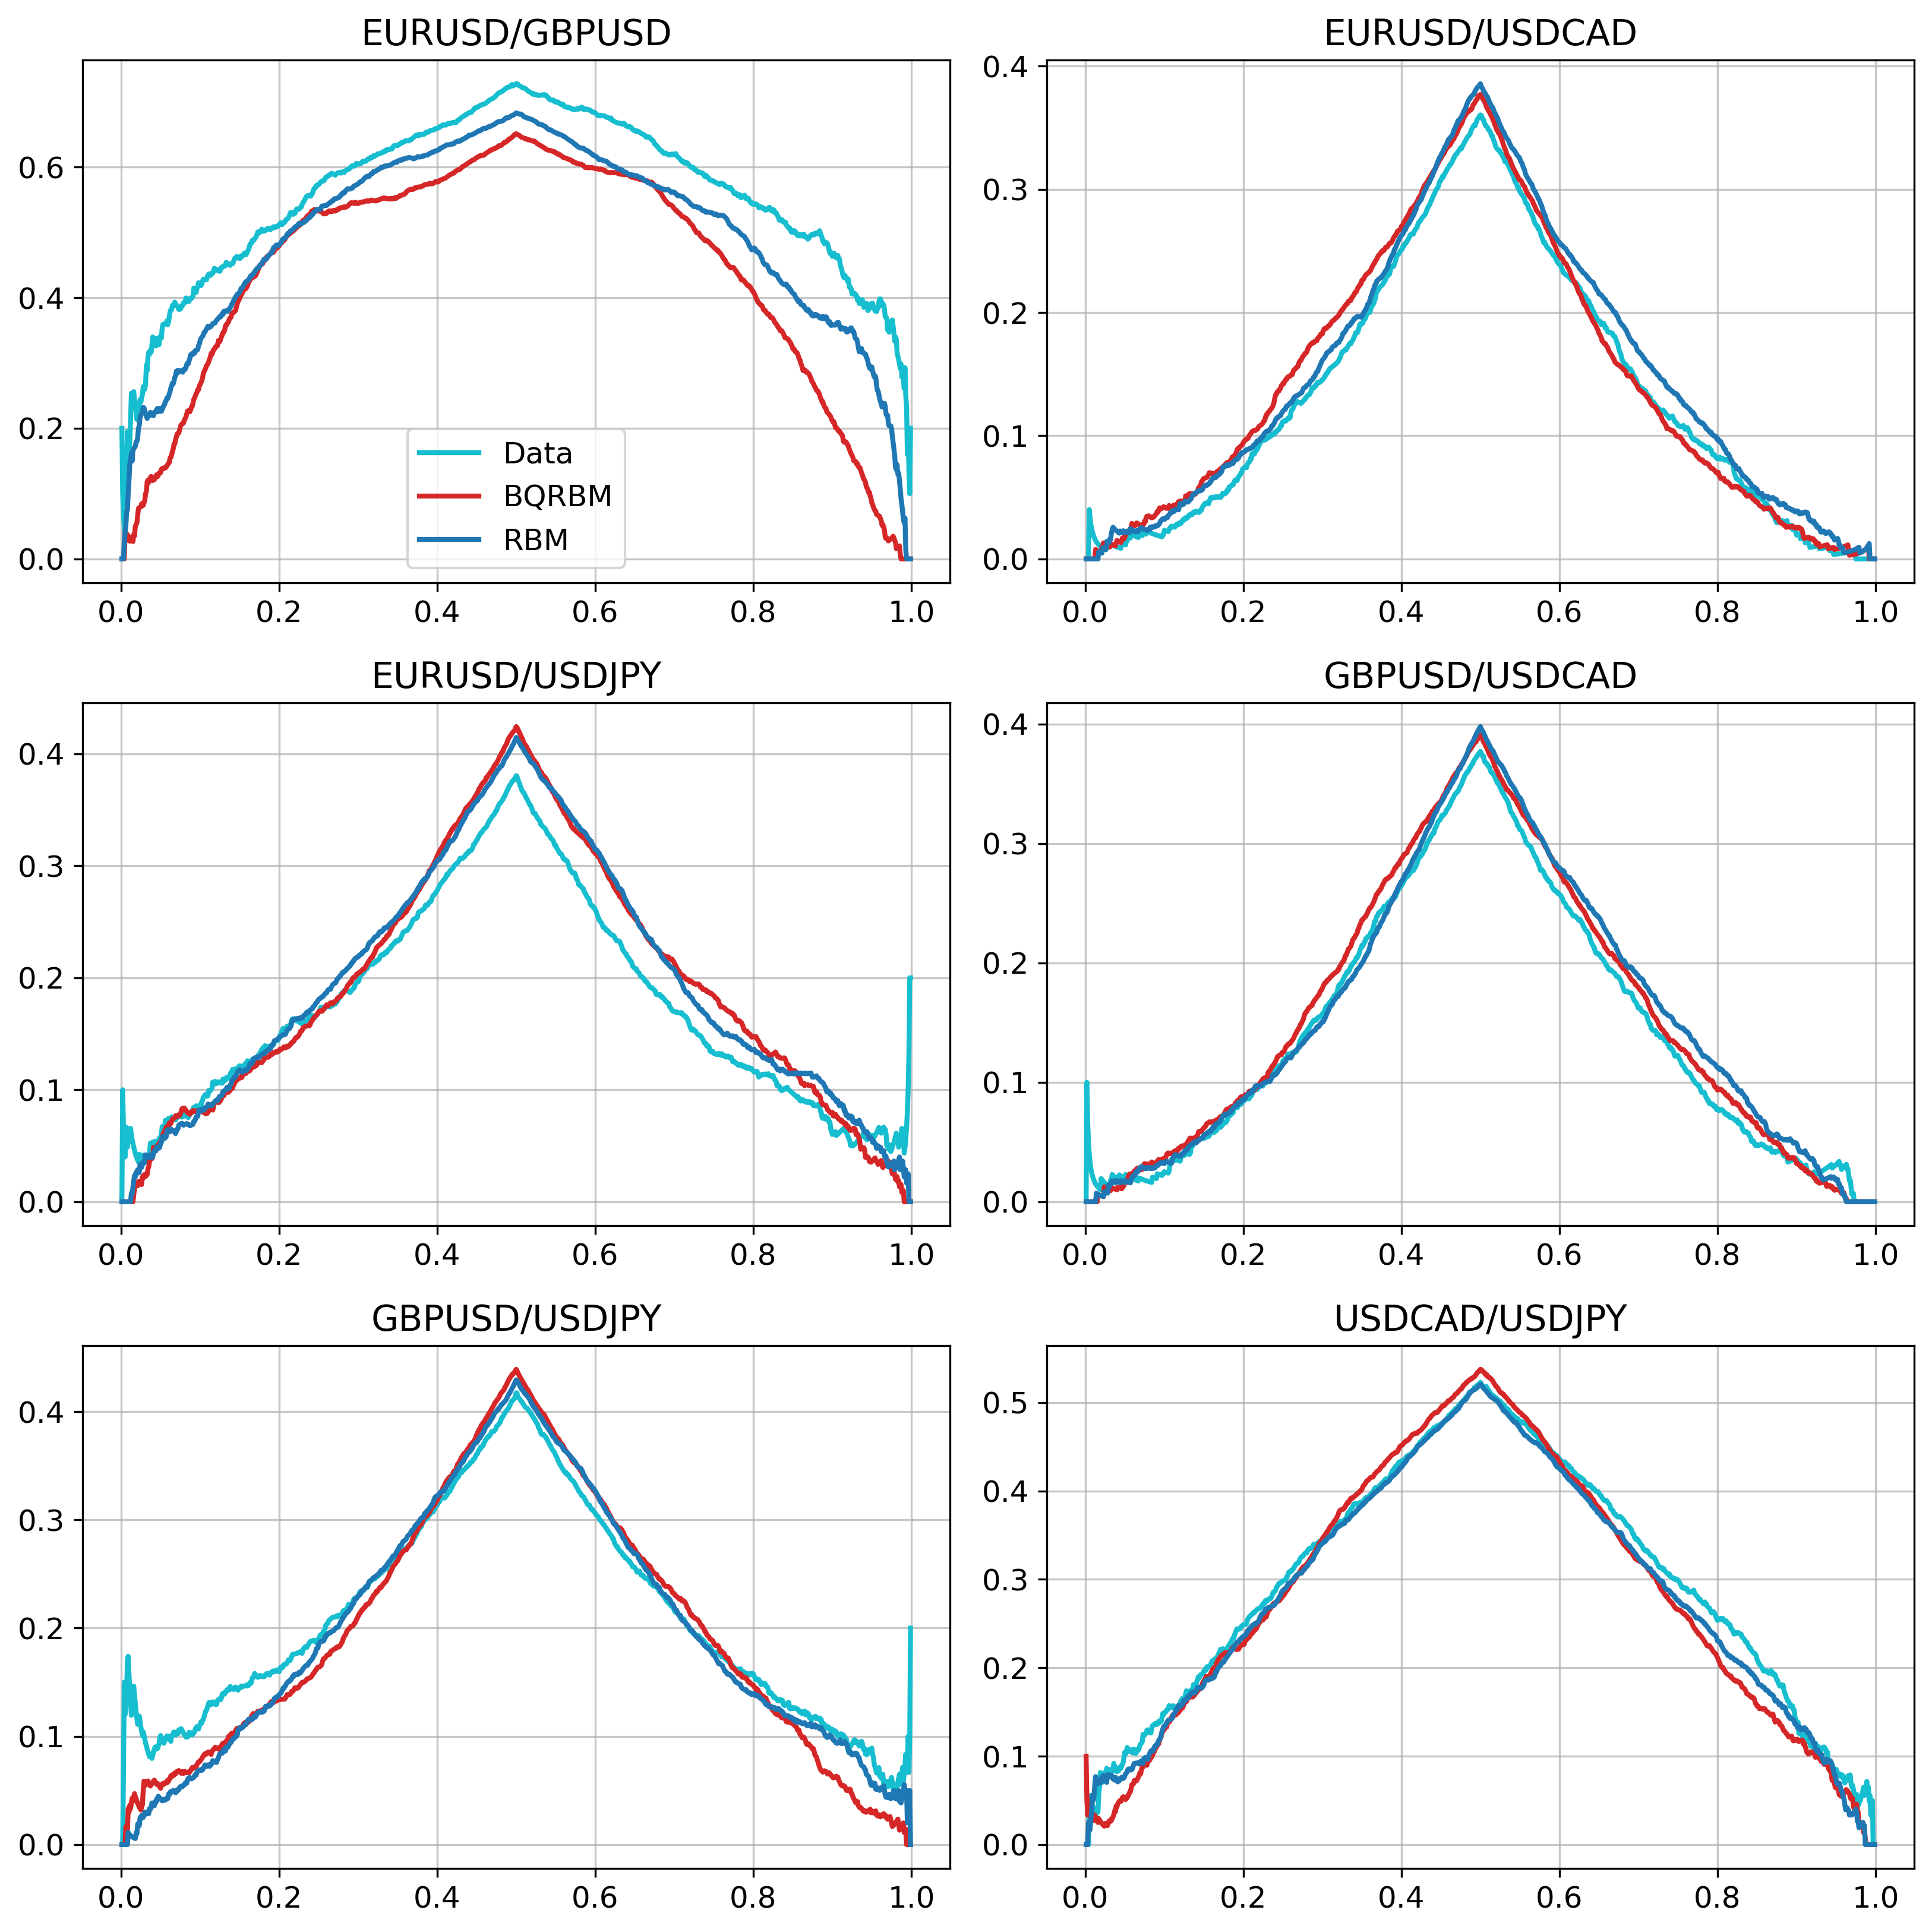

time: 9.76 s (started: 2022-03-17 15:24:03 +01:00)


In [27]:
tail_concentration_dfs = {}
tail_concentration_dfs["Data"] = log_returns
tail_concentration_dfs["BQRBM"] = samples_ensemble[1]
tail_concentration_dfs["RBM"] = load_artifact(
    rbm_artifacts_path / f"samples_ensemble/{1:03}.pkl"
)

combinations = list(itertools.combinations(log_returns.columns, 2))
colors = {
    "Data": "tab:cyan",
    "BQRBM": "tab:red",
    "RBM": "tab:blue",
}
fig, axs = plot_tail_concentrations_grid(tail_concentration_dfs, combinations, colors)
plt.savefig(plots_dir / "tail_concentrations.png")